In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Statistical tools
from scipy import stats
from scipy.stats import ttest_ind, yeojohnson, skew

# Regression and diagnostics
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Utility
import warnings
from datetime import datetime
import glob

# Keep the output clean
warnings.filterwarnings('ignore')

# Load cleaned dataset
df = pd.read_csv('dataset_cleaned.csv')


# Section 2: Exploratory Insights

## Section 2.1: Financial Seasonality & Margin Stability Overview

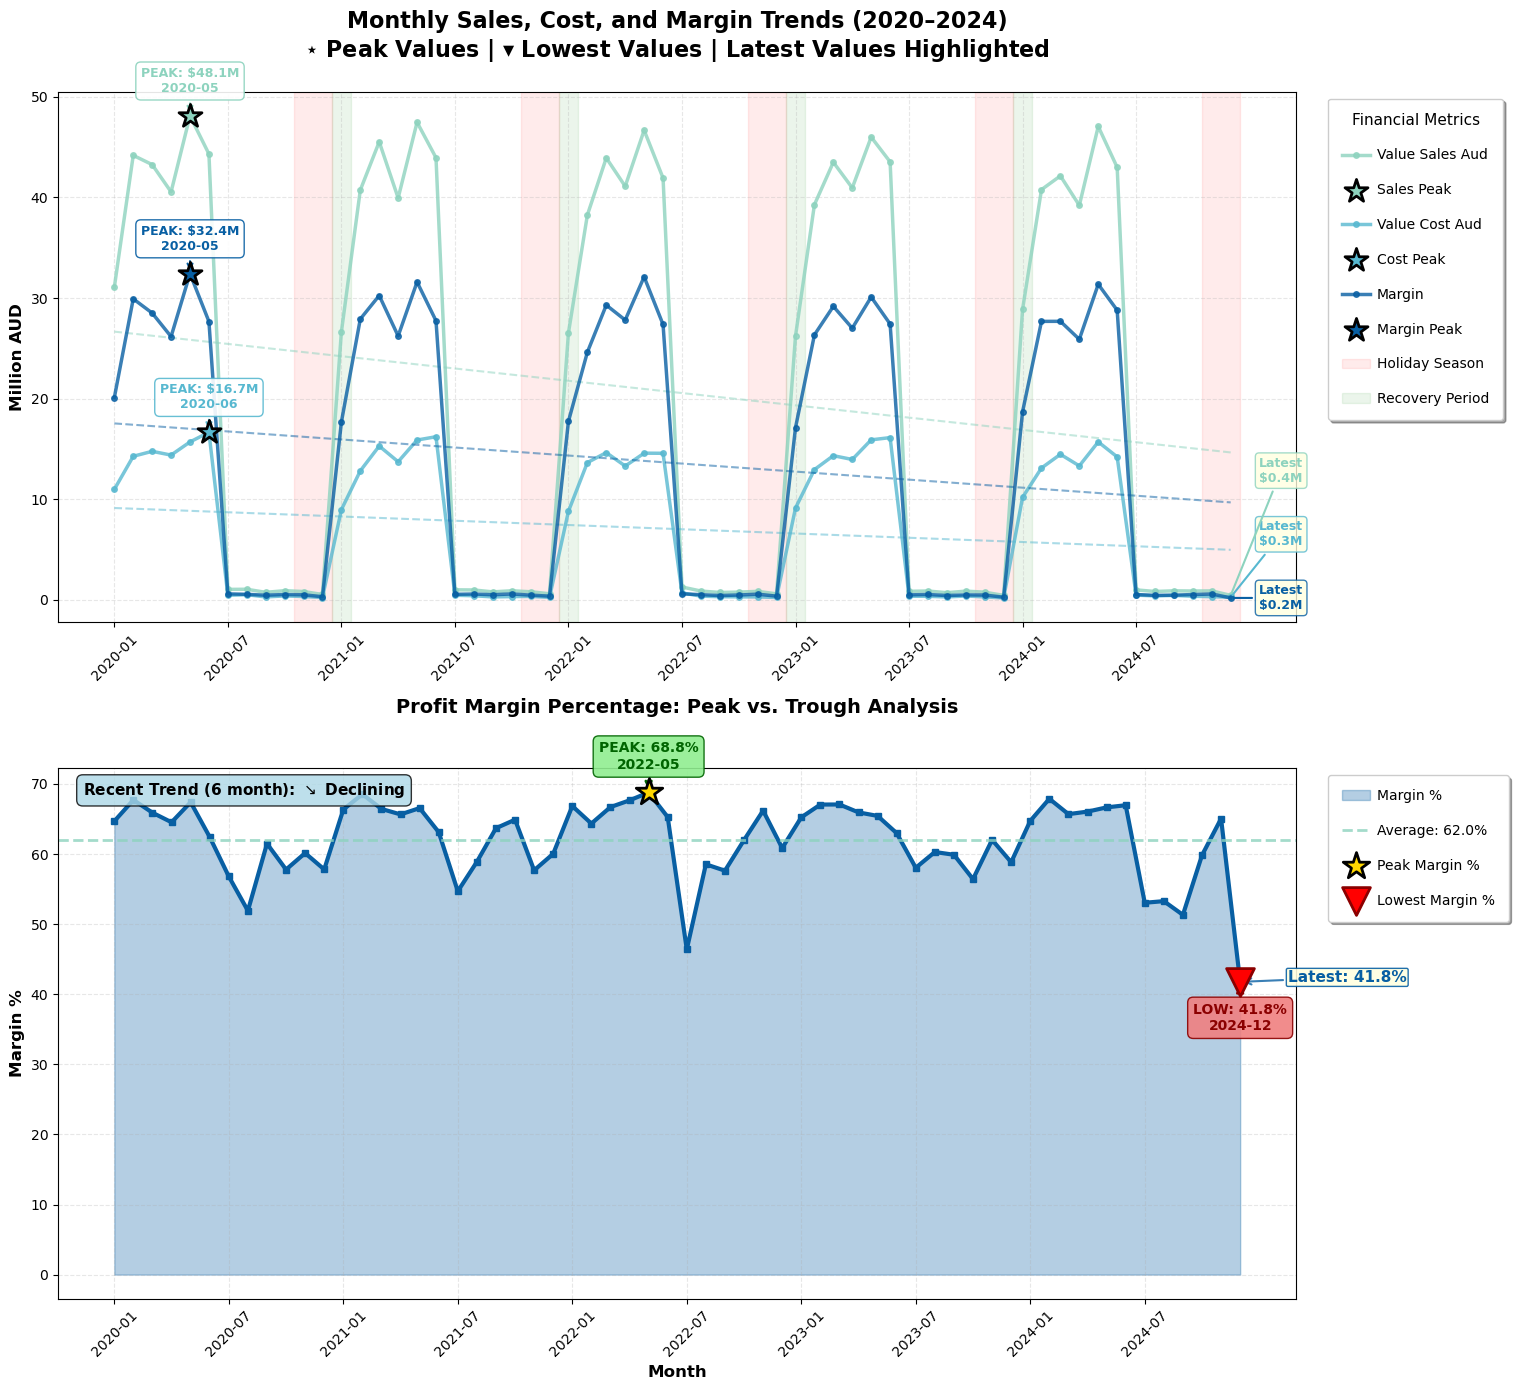

 ENHANCED FINANCIAL DASHBOARD - PEAK & TROUGH ANALYSIS

 Data Range: 2020-01 to 2024-12 (60 months)

METRIC               PEAK                      TROUGH                    LATEST         
--------------------------------------------------------------------------------
Sales                $  48.1M (2020-05)    $   0.4M (2023-12)    $   0.4M
Cost                 $  16.7M (2020-06)    $   0.2M (2023-12)    $   0.3M
Margin               $  32.4M (2020-05)    $   0.2M (2024-12)    $   0.2M

--------------------------------------------------------------------------------
Margin %               68.8% (2022-05)      41.8% (2024-12)      41.8%
Average Margin         62.0%

 KEY INSIGHTS:
   • Sales volatility: Peak-to-Trough = $47.7M
   • Margin volatility: 27.0 percentage points
   • Current margin vs. average: -20.2pp


In [2]:
# DATA PREPARATION AND MONTHLY FINANCIAL ANALYSIS
# Prepare time-series financial data, calculate monthly metrics,
# and aggregate values for visualisation.

# Convert accounting_date into datetime format for time-based operations.
df['accounting_date'] = pd.to_datetime(df['accounting_date'])

# Create margin as: sales value − cost value.
df['margin'] = df['value_sales_aud'] - df['value_cost_aud']

# Extract accounting month (YYYY-MM) for grouping.
df['month'] = df['accounting_date'].dt.to_period('M').astype(str)

# Group by month and calculate total sales, cost, and margin.
# Divide by 1e6 to display values in millions.
df_monthly = (
    df.groupby('month')[['value_sales_aud', 'value_cost_aud', 'margin']]
      .sum() / 1e6
)

# Sort months chronologically for correct time-series order.
df_monthly = df_monthly.sort_index()

# Compute monthly margin percentage: (margin / sales) × 100.
df_monthly['margin_pct'] = (df_monthly['margin'] / df_monthly['value_sales_aud']) * 100


# PLOTTING SETUP
# Create a 2-row layout:
#   - ax1: Sales, Cost, Margin trends
#   - ax2: Margin % analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14))

# Adjust layout so legends fit on the right.
plt.subplots_adjust(right=0.85)

# Define colours for Sales, Cost, and Margin.
cmap = cm.get_cmap("GnBu")
colors = [
    cmap(0.45),   # Sales
    cmap(0.6),    # Cost
    cmap(0.9)     # Margin
]

# Readable labels.
labels = ['Sales', 'Cost', 'Margin']

# Numeric x-axis for months.
x_range = range(len(df_monthly))

# Store latest-value annotations.
latest_annotations = []


# PLOT 1 — MONTHLY SALES, COST, AND MARGIN TRENDS
for i, col in enumerate(['value_sales_aud', 'value_cost_aud', 'margin']):

    # Plot the monthly line.
    ax1.plot(
        x_range, df_monthly[col],
        color=colors[i], linewidth=2.5,
        label=col.replace('_', ' ').replace('aud', 'AUD').title(),
        marker='o', markersize=4, alpha=0.8
    )

    # Add trend line using polynomial fitting.
    z = np.polyfit(x_range, df_monthly[col], 1)
    p = np.poly1d(z)
    ax1.plot(x_range, p(x_range), "--", color=colors[i], alpha=0.5, linewidth=1.5)

    # Get peak and trough months.
    max_idx = df_monthly[col].idxmax()
    min_idx = df_monthly[col].idxmin()
    max_val = df_monthly[col].max()
    min_val = df_monthly[col].min()

    # Convert month name to numeric axis position.
    max_x = df_monthly.index.get_loc(max_idx)
    min_x = df_monthly.index.get_loc(min_idx)

    # Highlight the peak point.
    ax1.scatter(
        max_x, max_val,
        color=colors[i], s=300, marker='*',
        edgecolors='black', linewidths=2, zorder=10,
        label=f'{labels[i]} Peak'
    )

    # Annotate peak.
    ax1.annotate(
        f'PEAK: ${max_val:.1f}M\n{max_idx}',
        xy=(max_x, max_val),
        xytext=(0, 15), textcoords='offset points',
        fontsize=9, fontweight='bold', color=colors[i],
        ha='center', va='bottom',
        bbox=dict(boxstyle="round,pad=0.4", facecolor='white',
                  edgecolor=colors[i], alpha=0.9),
        arrowprops=dict(arrowstyle='->', color=colors[i], lw=1.5)
    )

    # Capture latest value for annotation.
    latest_val = df_monthly.iloc[-1][col]
    latest_annotations.append({
        'val': latest_val,
        'label': f'Latest\n${latest_val:.1f}M',
        'color': colors[i]
    })


# Prevent overlapping labels for latest points.
latest_idx = len(df_monthly) - 1
latest_annotations.sort(key=lambda x: x['val'])

y_min, y_max = ax1.get_ylim()
min_dist = (y_max - y_min) * 0.12
label_positions = [item['val'] for item in latest_annotations]

for i in range(1, len(label_positions)):
    if label_positions[i] - label_positions[i-1] < min_dist:
        label_positions[i] = label_positions[i-1] + min_dist

# Draw latest-value labels.
for i, item in enumerate(latest_annotations):
    ax1.annotate(
        item['label'],
        xy=(latest_idx, item['val']),
        xytext=(latest_idx + 1.5, label_positions[i]),
        fontsize=9, fontweight='bold', color=item['color'],
        ha='left', va='center',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='lightyellow',
                  edgecolor=item['color'], alpha=0.8),
        arrowprops=dict(arrowstyle='-', color=item['color'], lw=1.5)
    )


# Shade seasonal periods: Nov–Dec (Holiday) and Jan (Recovery)
for year in range(2020, 2025):

    nov, dec, jan = f'{year}-11', f'{year}-12', f'{year+1}-01'

    # Shade Holiday season.
    if nov in df_monthly.index and dec in df_monthly.index:
        n, d = df_monthly.index.get_loc(nov), df_monthly.index.get_loc(dec)
        ax1.axvspan(n - 0.5, d + 0.5, alpha=0.08, color='red',
                    label='Holiday Season' if year == 2020 else "")

    # Shade January recovery.
    if jan in df_monthly.index:
        j = df_monthly.index.get_loc(jan)
        ax1.axvspan(j - 0.5, j + 0.5, alpha=0.08, color='green',
                    label='Recovery Period' if year == 2021 else "")


# Format Plot 1
ax1.set_title(
    r'Monthly Sales, Cost, and Margin Trends (2020–2024)'
    + '\n'
    + r'$\star$ Peak Values | $\blacktriangledown$ Lowest Values | Latest Values Highlighted',
    fontsize=16, fontweight='bold', pad=25
)

ax1.set_ylabel('Million AUD', fontsize=12, fontweight='bold')
ax1.set_xticks(range(0, len(df_monthly), 6))
ax1.set_xticklabels([df_monthly.index[i] for i in range(0, len(df_monthly), 6)], rotation=45)

ax1.legend(
    bbox_to_anchor=(1.02, 1), loc='upper left',
    frameon=True, fancybox=True, shadow=True,
    fontsize=10, title='Financial Metrics',
    title_fontsize=11, labelspacing=1.5, handletextpad=0.5, borderpad=1.0
)

ax1.grid(True, linestyle='--', alpha=0.3)



# PLOT 2 — MONTHLY MARGIN PERCENTAGE ANALYSIS
ax2.fill_between(
    x_range, df_monthly['margin_pct'],
    alpha=0.3, color=colors[2], label='Margin %'
)

ax2.plot(
    x_range, df_monthly['margin_pct'],
    color=colors[2], linewidth=3,
    marker='s', markersize=5
)

# Average margin line.
avg_margin = df_monthly['margin_pct'].mean()
ax2.axhline(
    y=avg_margin, color=colors[0],
    linestyle='--', alpha=0.8, linewidth=2,
    label=f'Average: {avg_margin:.1f}%'
)

# Peak & Trough of margin %.
m_max_idx = df_monthly['margin_pct'].idxmax()
m_min_idx = df_monthly['margin_pct'].idxmin()
m_max_val = df_monthly['margin_pct'].max()
m_min_val = df_monthly['margin_pct'].min()

m_max_x = df_monthly.index.get_loc(m_max_idx)
m_min_x = df_monthly.index.get_loc(m_min_idx)

# Annotate peak.
ax2.scatter(
    m_max_x, m_max_val,
    color='gold', s=400, marker='*',
    edgecolors='black', linewidths=2, zorder=10,
    label=r'Peak Margin %'
)

ax2.annotate(
    f'PEAK: {m_max_val:.1f}%\n{m_max_idx}',
    xy=(m_max_x, m_max_val),
    xytext=(0, 15), textcoords='offset points',
    fontsize=10, fontweight='bold', color='darkgreen',
    ha='center', va='bottom',
    bbox=dict(boxstyle="round,pad=0.4", facecolor='lightgreen',
              edgecolor='darkgreen', alpha=0.9),
    arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2)
)

# Annotate trough.
ax2.scatter(
    m_min_x, m_min_val,
    color='red', s=400, marker='v',
    edgecolors='darkred', linewidths=2, zorder=10,
    label=r'Lowest Margin %'
)

ax2.annotate(
    f'LOW: {m_min_val:.1f}%\n{m_min_idx}',
    xy=(m_min_x, m_min_val),
    xytext=(0, -15), textcoords='offset points',
    fontsize=10, fontweight='bold', color='darkred',
    ha='center', va='top',
    bbox=dict(boxstyle="round,pad=0.4", facecolor='lightcoral',
              edgecolor='darkred', alpha=0.9),
    arrowprops=dict(arrowstyle='->', color='darkred', lw=2)
)

# Latest margin %.
latest_margin = df_monthly['margin_pct'].iloc[-1]
ax2.annotate(
    f'Latest: {latest_margin:.1f}%',
    xy=(latest_idx, latest_margin),
    xytext=(latest_idx + 2.5, latest_margin),
    fontsize=11, fontweight='bold', color=colors[2],
    bbox=dict(boxstyle="round,pad=0.1", facecolor='lightyellow',
              alpha=0.9, edgecolor=colors[2]),
    arrowprops=dict(arrowstyle='->', color=colors[2],
                    alpha=0.8, lw=1.5)
)

# Recent trend (last 6 months).
if len(df_monthly) >= 6:

    margin_trend = np.polyfit(
        x_range[-6:], df_monthly['margin_pct'].iloc[-6:], 1
    )[0]

    trend_arrow = (
        r"$\nearrow$" if margin_trend > 0.1
        else r"$\searrow$" if margin_trend < -0.1
        else r"$\rightarrow$"
    )

    trend_desc = (
        "Improving" if margin_trend > 0.1
        else "Declining" if margin_trend < -0.1
        else "Stable"
    )

    ax2.text(
        0.02, 0.95,
        f'Recent Trend (6 month): {trend_arrow} {trend_desc}',
        transform=ax2.transAxes,
        fontsize=11, fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.4",
                  facecolor='lightblue', alpha=0.8)
    )

# Format Plot 2
ax2.set_title('Profit Margin Percentage: Peak vs. Trough Analysis',
              fontsize=14, fontweight='bold', pad=40)

ax2.set_ylabel('Margin %', fontsize=12, fontweight='bold')
ax2.set_xlabel('Month', fontsize=12, fontweight='bold')

ax2.set_xticks(range(0, len(df_monthly), 6))
ax2.set_xticklabels(
    [df_monthly.index[i] for i in range(0, len(df_monthly), 6)],
    rotation=45
)

ax2.legend(
    bbox_to_anchor=(1.02, 1), loc='upper left',
    frameon=True, fancybox=True, shadow=True,
    fontsize=10, labelspacing=1.5,
    handletextpad=0.5, borderpad=1.0
)

ax2.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# SUMMARY STATISTICS
print("=" * 80)
print(" ENHANCED FINANCIAL DASHBOARD - PEAK & TROUGH ANALYSIS")
print("=" * 80)

# Data coverage
print(f"\n Data Range: {df_monthly.index[0]} to {df_monthly.index[-1]} ({len(df_monthly)} months)")

print(f"\n{'METRIC':<20} {'PEAK':<25} {'TROUGH':<25} {'LATEST':<15}")
print("-" * 80)

# Sales / Cost / Margin table.
for i, col in enumerate(['value_sales_aud', 'value_cost_aud', 'margin']):
    max_idx = df_monthly[col].idxmax()
    min_idx = df_monthly[col].idxmin()
    max_val = df_monthly[col].max()
    min_val = df_monthly[col].min()
    latest_val = df_monthly[col].iloc[-1]

    metric_name = labels[i]
    print(f"{metric_name:<20} ${max_val:>6.1f}M ({max_idx})    "
          f"${min_val:>6.1f}M ({min_idx})    ${latest_val:>6.1f}M")

print("\n" + "-" * 80)

# Margin % table.
print(f"{'Margin %':<20} {m_max_val:>6.1f}% ({m_max_idx})    "
      f"{m_min_val:>6.1f}% ({m_min_idx})    {latest_margin:>6.1f}%")

print(f"{'Average Margin':<20} {avg_margin:>6.1f}%")

print("\n" + "=" * 80)
print(" KEY INSIGHTS:")
print(f"   • Sales volatility: Peak-to-Trough = "
      f"${df_monthly['value_sales_aud'].max() - df_monthly['value_sales_aud'].min():.1f}M")
print(f"   • Margin volatility: {m_max_val - m_min_val:.1f} percentage points")
print(f"   • Current margin vs. average: {latest_margin - avg_margin:+.1f}pp")
print("=" * 80)


### **1. Business Collapsed 99% from Peak**
The most important story in the data is a **massive, continuous decline**, not just regular ups and downs.
*   The business hit its highest point right at the beginning of the data (May 2020) and has been falling steadily for over 4 years.
*   Going from **48.1 million** at the peak to just **0.4 million** now is a **99% drop**. This looks like a business that had a one-time boom (like a viral product) that is completely over, or a product that has reached the end of its life. It's now running on less than 1% of its former size.

---

### **2. Profitability Improved After Sales Started Falling**
There's an interesting gap between when **sales** dropped and when **profit margins** got better.
*   Sales were highest in **2020**, but the best profit margin (68.8%) didn't happen until **May 2022**—two years later.
*   This means that even while the total business was getting smaller, it became more efficient. The company likely cut low-profit sales and reduced costs, making more money on each remaining dollar of sales, even as the overall amount of sales shrank.

---

### **3. Small Scale Now Hurts Profitability**
The business is now so small that it's losing its efficiency.
*   The current profit margin (**41.8%**) is much worse than the historical average (**62.0%**) and the best-ever margin (**68.8%**).
*   At only 0.4 million in sales, fixed costs like rent or base staffing now eat up a much bigger chunk of each dollar earned than they did at 48 million. The efficiency gains made in 2022 have been wiped out by the collapse in scale.

---

### **4. Seasonal Ups and Downs Barely Matter Anymore**
*   The data still shows a yearly pattern: highs in **May/June** and lows in **December**.
*   However, because the business is now so tiny, these seasonal swings are almost meaningless. A "peak" month in 2024 is just a small blip compared to what a peak month was in 2020.

---

### **5. Costs Fell with Sales, Preventing Losses**
*   Costs dropped almost exactly as much as sales did (about **98%** vs. **99%**).
*   This shows the business has mostly **variable costs**, not **fixed costs** (like permanent staff or long-term leases). Because of this, the business could shrink its spending as revenue vanished, which is why it's still making a small profit ($0.2M) instead of losing money.

## Section 2.2: Margin Composition by Product Category: 2020–2024

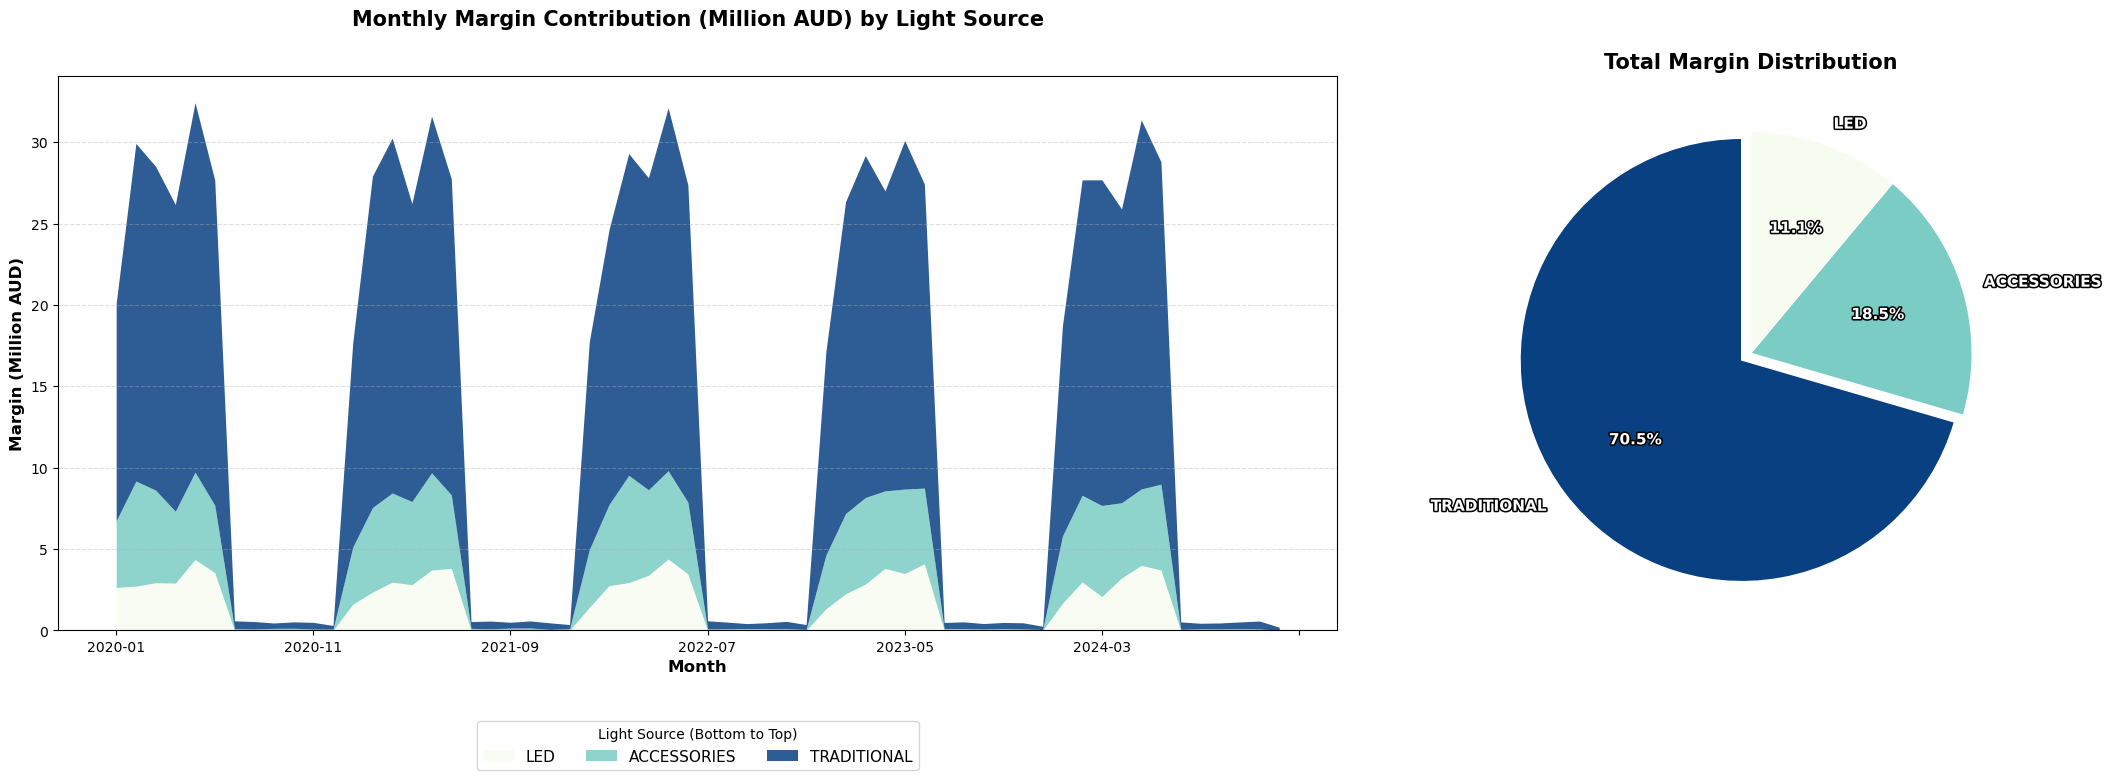

 LIGHT SOURCE MARGIN ANALYSIS

Rank   Light Source              Total        Share      Cumul %    Avg/Month   
------------------------------------------------------------------------------------------
🥇      TRADITIONAL               $   575.5M      70.5%      70.5%    $    9.59M
🥈      ACCESSORIES               $   150.7M      18.5%      88.9%    $    2.51M
🥉      LED                       $    90.3M      11.1%     100.0%    $    1.51M


In [3]:
# 1. DATA PREPARATION
# Group margin by month and light source, then reshape for analysis.

df_by_light = (
    df.groupby(['month', 'light_source'])[['margin']]
      .sum()
      .reset_index()
)

df_light_pivot = df_by_light.pivot(
    index='month',
    columns='light_source',
    values='margin'
) / 1e6  # convert to million AUD

df_light_pivot = df_light_pivot.sort_index().fillna(0)
df_positive = df_light_pivot.clip(lower=0)

product_totals_desc = df_positive.sum().sort_values(ascending=False)
product_totals_asc = df_positive.sum().sort_values(ascending=True)

total_margin = product_totals_desc.sum()
proportions = (product_totals_desc / total_margin) * 100


# 2. COLOR MAP (dark = stronger performers)

cmap = cm.get_cmap("GnBu")
n_products = len(product_totals_desc)

# Largest product gets the darkest shade, smallest gets the lightest.
colors_list = [
    cmap(1 - (i / max(n_products - 1, 1)))
    for i in range(n_products)
]

# Map each product to a color based on total margin rank.
color_map = {
    product: color
    for product, color in zip(product_totals_desc.index, colors_list)
}


# 3. VISUALISATIONS: stacked area (time) + pie chart (share)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(22, 8),
    gridspec_kw={'width_ratios': [1.8, 1]}
)

# --- Stacked area chart: monthly margin by light source ---

df_sorted = df_positive[product_totals_asc.index]
area_colors = [color_map[col] for col in df_sorted.columns]

df_sorted.plot(
    ax=ax1,
    kind='area',
    stacked=True,
    alpha=0.85,
    color=area_colors,
    linewidth=0
)

ax1.set_title(
    "Monthly Margin Contribution (Million AUD) by Light Source\n",
    fontsize=15, weight='bold', pad=20
)
ax1.set_ylabel("Margin (Million AUD)", fontsize=12, weight='bold')
ax1.set_xlabel("Month", fontsize=12, weight='bold')
ax1.grid(True, axis='y', linestyle='--', alpha=0.4)

ax1.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    title="Light Source (Bottom to Top)",
    fontsize=11
)

# --- Pie chart: total margin distribution by light source ---

import matplotlib.patheffects as PathEffects

pie_data = product_totals_desc
pie_colors = [color_map[label] for label in pie_data.index]

# Slightly explode the top performer.
explode = [0.05 if i == 0 else 0 for i in range(len(pie_data))]

wedges, texts, autotexts = ax2.pie(
    pie_data.values,
    labels=pie_data.index,
    autopct="%1.1f%%",
    startangle=90,
    explode=explode,
    colors=pie_colors,
    textprops={'fontsize': 11, 'weight': 'bold', 'color': 'white'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)

# Add black outline stroke to improve text readability.
for t in texts + autotexts:
    t.set_color('white')
    t.set_path_effects([
        PathEffects.Stroke(linewidth=2.2, foreground='black'),
        PathEffects.Normal()
    ])

ax2.set_title("Total Margin Distribution", fontsize=15, weight='bold')

plt.tight_layout()
plt.show()


# 4. SUMMARY TABLE (console output)

print("=" * 90)
print(" LIGHT SOURCE MARGIN ANALYSIS")
print("=" * 90)

summary_df = pd.DataFrame({
    'Total Margin (M$)': product_totals_desc,
    'Contribution (%)': proportions,
    'Cumulative (%)': proportions.cumsum(),
    'Avg Monthly (M$)': df_positive[product_totals_desc.index].mean(),
})

print(f"\n{'Rank':<6} {'Light Source':<25} {'Total':<12} "
      f"{'Share':<10} {'Cumul %':<10} {'Avg/Month':<12}")
print("-" * 90)

for i, (idx, row) in enumerate(summary_df.iterrows(), start=1):
    rank_icon = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i:>2}"
    print(
        f"{rank_icon:<6} {idx:<25} "
        f"${row['Total Margin (M$)']:>8.1f}M    "
        f"{row['Contribution (%)']:>6.1f}%    "
        f"{row['Cumulative (%)']:>6.1f}%    "
        f"${row['Avg Monthly (M$)']:>8.2f}M")



### 1. Traditional Dominance
* "Traditional" light sources generate **70.5% (575.5M)** of the total margin.
* The company is currently acting as a "Cash Cow" regarding legacy technology (Fluorescent, Halogen, HID). Generating 575M in margin from Traditional sources suggests the company has a massive installed base and is likely pricing aggressively on replacements as competitors exit this space.
* This is a dangerous position. The global lighting market has largely shifted to LED. Relying on Traditional sources for 70% of profitability indicates the company is **over-exposed to obsolescence**. When regulations (banning mercury/halogen) or retrofits accelerate, 70% of the company's profit engine will evaporate.
*  The revenue stream is finite. Unlike LED, which is a growing market, Traditional is a shrinking pie. The company is extracting maximum value from a dying technology, but it lacks a "Star" product to replace it.

### 2. LED Underperformance
* LED contributes only **11.1% ($90.3M)** to the margin.
*   **Margin Compression or Low Volume?** There are two possibilities here:
    1.  **Low Volume:** The company simply isn't selling enough LED product (losing market share to agile competitors).
    2.  **Low Margin:** They are selling high volumes of LED, but the margins are razor-thin due to commoditization.
*   **The "Gap" Analysis:** A healthy modern lighting company should see LED representing 50-80% of sales/margin. Being at 11% suggests the company is **late to the transition** or possesses an uncompetitive LED product portfolio (perhaps strictly resale/importing without value-add).

### 3. Accessories Strength
* Accessories provide **18.5% ($150.7M)** of margin, significantly outperforming LED.
* Accessories (drivers, tracks, mounting gear) often command higher markups than the fixtures themselves because they are proprietary or required for installation.
* A key question is whether these accessories are tied to the *Traditional* fixtures or the *LED* fixtures. If these are replacement ballasts/starters for traditional lights, this revenue stream will die alongside the Traditional category. If they are control systems for LEDs, it is a promising growth vector.

# Section 2.3: Top District Sales & Margin Insights: Performance Leaders, Volume Drivers, and Areas of Concern



Creating Plot 1...


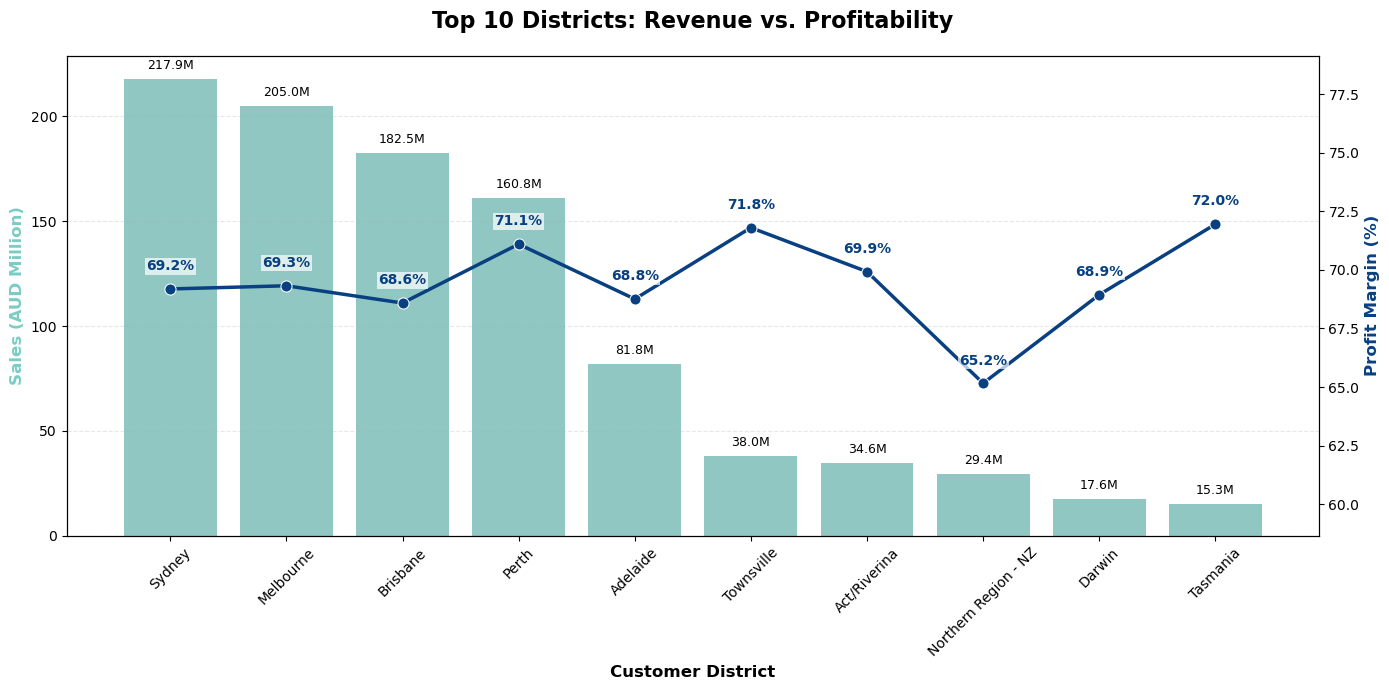

Creating Plot 2: Performance Matrix...


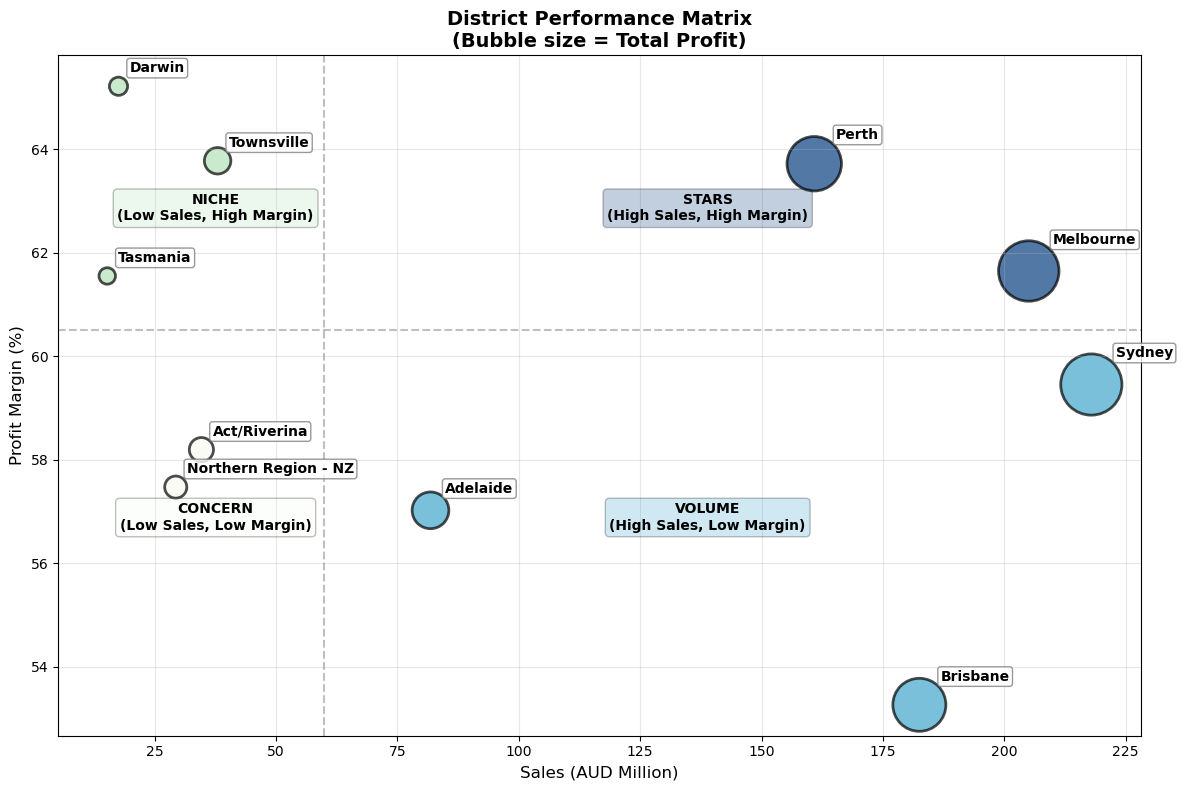

In [4]:
# 0. COLOR UTILITIES (GnBu THEME)
# Helper to generate a list of GnBu colors for consistent styling.

GNBU = cm.get_cmap("GnBu")

def gnbu(n, reverse=False):
    """
    Return n evenly spaced colors from the GnBu colormap.
    If reverse=True, return them from darkest to lightest.
    """
    if n <= 1:
        cols = [GNBU(0.5)]
    else:
        cols = [GNBU(i / (n - 1)) for i in range(n)]
    return cols[::-1] if reverse else cols


# 1. SETUP & CONFIGURATION
# Map district codes to readable district names.

district_mapping = {
    200: 'Sydney', 210: 'Act/Riverina', 300: 'Melbourne', 310: 'Tasmania',
    400: 'Brisbane', 410: 'Townsville', 500: 'Adelaide', 510: 'Darwin',
    520: 'Inlite - NZ', 530: 'South Island - NZ', 535: 'Central Region - NZ',
    540: 'Northern Region - NZ', 545: 'Head Office NZ', 600: 'Perth',
    710: 'Head Office Sales', 720: 'Intercompany Sales'
}


# 2. CONSOLIDATED DATA PREPARATION (TOP 10)
# Filter valid rows, aggregate by district, and compute sales, profit, and margin.

df_clean = df[df['value_sales_aud'] > 0].copy()

df_agg = df_clean.groupby('customer_district_code', observed=True).agg(
    sales_total=('value_sales_aud', 'sum'),
    cost_total=('value_cost_aud', 'sum')
).reset_index()

df_agg['margin_pct'] = ((df_agg['sales_total'] - df_agg['cost_total']) / df_agg['sales_total']) * 100
df_agg['sales_millions'] = df_agg['sales_total'] / 1_000_000
df_agg['profit_millions'] = (df_agg['sales_total'] - df_agg['cost_total']) / 1_000_000

df_agg['district_name'] = df_agg['customer_district_code'].astype(int).map(district_mapping)
df_agg = df_agg[df_agg['district_name'].notna()]
df_agg = df_agg[~df_agg['district_name'].isin(['Intercompany Sales', 'Head Office Sales'])]

df_top10 = df_agg.sort_values("sales_total", ascending=False).head(10).reset_index(drop=True)


# 3. PLOT 1: DUAL AXIS (BAR + LINE) WITH GNBU THEME
# Bars show sales; line shows profit margin for top 10 districts.

print("Creating Plot 1...")

# Use three GnBu colors: light, mid, dark.
c_light, c_mid, c_dark = gnbu(3)

fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot for sales (mid GnBu).
sns.barplot(
    x='district_name',
    y='sales_millions',
    data=df_top10,
    ax=ax1,
    color=c_mid,
    alpha=0.9
)

ax1.set_ylabel("Sales (AUD Million)", fontsize=12, fontweight='bold', color=c_mid)
ax1.set_xlabel("Customer District", fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Add labels on bars.
for p in ax1.patches:
    ax1.annotate(
        f'{p.get_height():.1f}M',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=9, color='black',
        xytext=(0, 5), textcoords='offset points'
    )

# Line plot for margin (dark GnBu) on secondary axis.
ax2 = ax1.twinx()
sns.lineplot(
    x='district_name',
    y='margin_pct',
    data=df_top10,
    ax=ax2,
    color=c_dark,
    marker='o',
    linewidth=2.5,
    markersize=8
)

ax2.set_ylabel("Profit Margin (%)", fontsize=12, fontweight='bold', color=c_dark)

# Add margin labels above points.
for x, y in zip(range(len(df_top10)), df_top10['margin_pct']):
    ax2.text(
        x, y + 0.8,
        f"{y:.1f}%",
        color=c_dark,
        ha='center',
        fontsize=10,
        fontweight='bold',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
    )

ax2.set_ylim(df_top10['margin_pct'].min() * 0.9, df_top10['margin_pct'].max() * 1.1)

plt.title("Top 10 Districts: Revenue vs. Profitability",
          fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


# 4. DATA PREP FOR PLOT 2: PERFORMANCE MATRIX
# Prepare district-level sales, average margin, and profit for top 10.

print("Creating Plot 2: Performance Matrix...")

df_valid_plot2 = df[df['value_sales_aud'] > 0].copy()

df_valid_plot2['profit_margin_pct'] = (
    (df_valid_plot2['value_sales_aud'] - df_valid_plot2['value_cost_aud'])
    / df_valid_plot2['value_sales_aud']
) * 100

df_top10_plot2 = df_valid_plot2.groupby('customer_district_code', observed=True).agg(
    sales_total_aud=('value_sales_aud', 'sum'),
    avg_margin_pct=('profit_margin_pct', 'mean')
).reset_index()

df_top10_plot2['district_name'] = df_top10_plot2['customer_district_code'].astype(int).map(district_mapping)
df_top10_plot2 = df_top10_plot2[df_top10_plot2['district_name'].notna()]
df_top10_plot2 = df_top10_plot2[~df_top10_plot2['district_name'].isin(['Intercompany Sales', 'Head Office Sales'])]
df_top10_plot2 = df_top10_plot2.sort_values("sales_total_aud", ascending=False).head(10).reset_index(drop=True)

df_top10_plot2['sales_millions'] = (df_top10_plot2['sales_total_aud'] / 1_000_000).round(2)

df_top10_plot2['profit_millions'] = (
    df_top10_plot2['sales_millions'] * df_top10_plot2['avg_margin_pct'] / 100
).round(2)


# 5. PLOT 2: PERFORMANCE MATRIX WITH GNBU QUADRANTS
# Bubble chart by sales and margin, with quadrants for Stars, Niche, Volume, Concern.

fig, ax = plt.subplots(figsize=(12, 8))

# Median thresholds for sales and margin.
sales_median = df_top10_plot2['sales_millions'].median()
margin_median = df_top10_plot2['avg_margin_pct'].median()

# Four GnBu colors for quadrant categories.
q_light, q_med, q_meddark, q_dark = gnbu(4)

# Assign point colors based on quadrant.
point_colors = []
for sales, margin in zip(df_top10_plot2['sales_millions'], df_top10_plot2['avg_margin_pct']):
    if sales >= sales_median and margin >= margin_median:
        point_colors.append(q_dark)        # STARS
    elif sales >= sales_median and margin < margin_median:
        point_colors.append(q_meddark)     # VOLUME
    elif sales < sales_median and margin >= margin_median:
        point_colors.append(q_med)         # NICHE
    else:
        point_colors.append(q_light)       # CONCERN

# Bubble chart (size = total profit).
scatter = ax.scatter(
    df_top10_plot2['sales_millions'],
    df_top10_plot2['avg_margin_pct'],
    s=df_top10_plot2['profit_millions'] * 15,
    c=point_colors,
    alpha=0.7,
    edgecolors='black',
    linewidth=2
)

# Add district labels with offset depending on bubble size.
for i, txt in enumerate(df_top10_plot2['district_name']):
    bubble_size = df_top10_plot2['profit_millions'].iloc[i] * 15
    offset_distance = max(8, (bubble_size ** 0.5) * 0.4)
    
    ax.annotate(
        txt,
        (df_top10_plot2['sales_millions'].iloc[i], df_top10_plot2['avg_margin_pct'].iloc[i]),
        xytext=(offset_distance, offset_distance),
        textcoords='offset points',
        fontsize=10,
        fontweight='bold',
        color='black',
        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8, edgecolor='gray'),
        ha='left', va='bottom'
    )

# Draw median lines to create quadrants.
ax.axvline(x=sales_median, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=margin_median, color='gray', linestyle='--', alpha=0.5)

# Compute min/max values for label positioning.
sales_min, sales_max = df_top10_plot2['sales_millions'].min(), df_top10_plot2['sales_millions'].max()
margin_min, margin_max = df_top10_plot2['avg_margin_pct'].min(), df_top10_plot2['avg_margin_pct'].max()

def midpoint(a, b):
    return (a + b) / 2

# Quadrant labels with soft GnBu backgrounds.
ax.text(
    midpoint(sales_median, sales_max), midpoint(margin_median, margin_max),
    'STARS\n(High Sales, High Margin)', ha='center', va='center',
    fontsize=10, fontweight='bold',
    bbox=dict(boxstyle="round,pad=0.3", facecolor=q_dark, alpha=0.25)
)

ax.text(
    midpoint(sales_min, sales_median), midpoint(margin_median, margin_max),
    'NICHE\n(Low Sales, High Margin)', ha='center', va='center',
    fontsize=10, fontweight='bold',
    bbox=dict(boxstyle="round,pad=0.3", facecolor=q_med, alpha=0.25)
)

ax.text(
    midpoint(sales_median, sales_max), midpoint(margin_min, margin_median),
    'VOLUME\n(High Sales, Low Margin)', ha='center', va='center',
    fontsize=10, fontweight='bold',
    bbox=dict(boxstyle="round,pad=0.3", facecolor=q_meddark, alpha=0.25)
)

ax.text(
    midpoint(sales_min, sales_median), midpoint(margin_min, margin_median),
    'CONCERN\n(Low Sales, Low Margin)', ha='center', va='center',
    fontsize=10, fontweight='bold',
    bbox=dict(boxstyle="round,pad=0.3", facecolor=q_light, alpha=0.25)
)

# Axis labels and title.
ax.set_xlabel('Sales (AUD Million)', fontsize=12)
ax.set_ylabel('Profit Margin (%)', fontsize=12)
ax.set_title('District Performance Matrix\n(Bubble size = Total Profit)',
             fontsize=14, fontweight='bold')

# Add small padding on axes.
x_pad = (sales_max - sales_min) * 0.05
y_pad = (margin_max - margin_min) * 0.05
ax.set_xlim(sales_min - x_pad, sales_max + x_pad)
ax.set_ylim(margin_min - y_pad, margin_max + y_pad)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 1. The Core Split: Sydney vs. Melbourne
*   **Sydney** is the revenue king (**217.9M**) but fails on efficiency. With an average margin of **59.46%**, it sits *below* the company median (60.5%). This classifies it as a **VOLUME** player—it generates cash by churning through transactions, not by optimizing value.
*   **Melbourne** is the **STAR**. It generates nearly equal revenue (**205.0M**) but maintains a margin of **61.65%** (above the median).
*   **The Takeaway:** Melbourne is the operational benchmark. If Sydney operated at Melbourne’s margin efficiency, the company would gain millions in pure profit without needing to find a single new customer.

---

### 2. The Danger Zone: Brisbane
Brisbane represents the highest risk in the portfolio.
*   **Revenue:** High ($182.5M).
*   **Margin:** **53.27%** (The lowest in the top 10).
* Brisbane is **7.2% below the median margin**. This suggests the district is "buying revenue" by offering heavy discounts. While the sales figures look good on a leaderboard, the profitability quality is poor. This is a classic "busy fool" scenario—high activity, low quality return.

---

### 3. The Unsung Hero: Perth
Perth is arguably the best-performing district relative to its size.
*   It generates substantial volume ($160.85M) while maintaining the **second-highest margin (63.72%)** of the major players.
*   Perth proves we do not need to discount heavily (like Brisbane) to achieve high volume.

---

### 4. The Niche Players (Townsville, Darwin, Tasmania)
These districts are small but highly disciplined.
*   **Characteristics:** Low Sales (<$40M) but High Margins (>61%).
*   **Darwin** has the highest average margin in the entire dataset (**65.22%**).
*   These regions are likely geographically isolated, allowing them to command higher prices due to less competition. They are profitable, but they cannot scale to match the revenue of the major cities.

---

### 5. The "Fix or Exit" List (Concerns)
Two districts are failing on both metrics (Low Sales / Low Margin):
1.  **Act/Riverina** (34M Sales / 58.2% Margin)
2.  **Northern Region - NZ** (29M Sales / 57.5% Margin)
*   These districts are not generating enough volume to justify their low margins, nor are they premium enough to be considered "Niche." They are currently a drain on resources relative to the return.

---

#### Recommendations

1.  **Audit Brisbane:** Immediate review of discounting practices. The margin gap (53% vs 60% median) is unacceptable for a major district.
2.  **Clone Melbourne's Model:** Identify what Melbourne does differently than Sydney (pricing discipline, product mix) and implement it in Sydney.
3.  **Protect Perth:** Ensure Perth's management is retained; they are delivering the ideal balance of Volume and Margin.
4.  **Review NZ & Act/Riverina:** Determine if the low margins are due to high logistics costs or poor pricing. If profitability cannot improve, consider restructuring.

# Section 2.4: Currency-Based Margin Disparities: USD Underperformance vs. Strong EUR Profitability



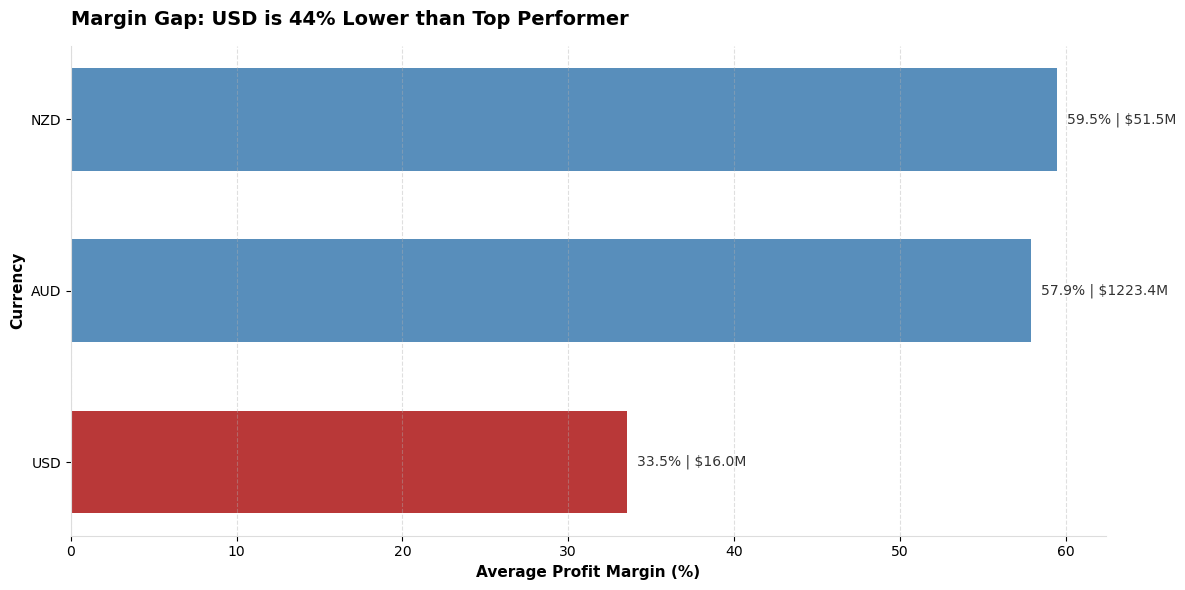

In [5]:
# 1. DATA PREPARATION
# Filter valid rows and calculate row-level profit margin.

df_valid = df[df['value_sales_aud'] > 0].copy()

# Calculate profit margin (%) for each transaction.
df_valid['profit_margin'] = (
    (df_valid['value_sales_aud'] - df_valid['value_cost_aud']) / df_valid['value_sales_aud']
) * 100

# Group by currency and compute summary metrics.
currency_stats = (
    df_valid.groupby('currency')
    .agg(
        avg_profit_margin=('profit_margin', 'mean'),
        total_sales=('value_sales_aud', 'sum'),
        transaction_count=('currency', 'count')
    )
    .reset_index()
)

# Convert total sales to millions and sort by average margin (ascending).
# Sorting ascending so the lowest margin appears at the bottom of the barh axis range.
currency_stats['total_sales_million'] = currency_stats['total_sales'] / 1e6
currency_stats = currency_stats.sort_values('avg_profit_margin', ascending=True)


# 2. PLOT CONFIGURATION
# Highlight the worst-performing currency in red and others in blue.

worst_currency = currency_stats.iloc[0]['currency']  # lowest margin after sort
colors = ['firebrick' if c == worst_currency else 'steelblue' for c in currency_stats['currency']]

fig, ax = plt.subplots(figsize=(12, 6))

# Horizontal bar chart of average profit margin by currency.
bars = ax.barh(
    currency_stats['currency'],
    currency_stats['avg_profit_margin'],
    color=colors,
    alpha=0.9,
    height=0.6
)


# 3. ANNOTATIONS & STYLING
# Add labels with margin and sales to each bar, and format the chart.

for bar, sales in zip(bars, currency_stats['total_sales_million']):
    width = bar.get_width()
    label_text = f'{width:.1f}% | ${sales:.1f}M'
    
    # Place text slightly to the right of each bar with dynamic padding.
    ax.text(
        width + (currency_stats['avg_profit_margin'].max() * 0.01),
        bar.get_y() + bar.get_height() / 2,
        label_text,
        va='center',
        fontsize=10,
        fontweight='medium',
        color='#333333'
    )

# Compute margin gap between best and worst currencies.
top_curr = currency_stats.iloc[-1]['avg_profit_margin']
bot_curr = currency_stats.iloc[0]['avg_profit_margin']
diff_pct = ((top_curr - bot_curr) / top_curr) * 100

# Dynamic title describing the margin gap.
ax.set_title(
    f'Margin Gap: {worst_currency} is {diff_pct:.0f}% Lower than Top Performer',
    fontsize=14,
    fontweight='bold',
    pad=15,
    loc='left'
)

ax.set_xlabel('Average Profit Margin (%)', fontsize=11, fontweight='bold')
ax.set_ylabel('Currency', fontsize=11, fontweight='bold')

# Light clean-up of chart styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_color('#DDDDDD')
ax.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


###  The Critical Issue: USD Performance
**USD is the "Red Bar"** that the code logic would highlight.
*   With a margin of **33.5%**, USD is performing significantly worse than the company standard. It is **43.6% less efficient** than the top performer (NZD).
*   Despite the poor margin, the volume is low (**$15.96M**).
*   This suggests the US market might be in an "entry phase" where the company is sacrificing margin for growth, or there are high variable costs specific to the US (e.g., international shipping, tariffs, or heavy discounting) eating into profits.

---

### The Core Engine: AUD Dominance
**AUD represents the overwhelming majority of the business.**
*   AUD sales are **$1,223.36M** (1.2 Billion). This dwarfs the other two currencies combined.
*   A margin of **57.91%** on this volume is excellent. It is very close to the top performer (NZD).
*   The company is likely Australian-based or has Australia as its mature home market. Because the margin is high *and* volume is massive, **this is the "Cash Cow."** Any slight drop in AUD margin would be far more catastrophic to the bottom line than the poor performance of USD.

---

### The Benchmark: NZD Efficiency
**NZD is the "Top Performer"** used for the gap calculation.
*   It holds the highest efficiency at **59.5%**.
*   While the volume is modest ($51.5M), NZD proves that high margins are possible outside of the primary AUD market.
*   Management should investigate *why* NZD is so efficient. Are logistics to New Zealand cheaper? Is the product mix different? These lessons could potentially be applied to fix the broken USD margins.

---
#### Recommendation
* **USD:** Requires immediate margin reconstruction (pricing or cost analysis) before any investment in volume growth.
* **AUD:** Priorities are stability and retention. This revenue stream supports the entire operation.
* **Structural Review:** The sharp divergence between USD (33%) and ANZ markets (58-59%) points to a structural cost disadvantage in the US supply chain rather than simple sales variance.

# Section 2.5: Top Item Classes by Sales, Profit Margin, and Share: Identifying High Performers and Underperformers



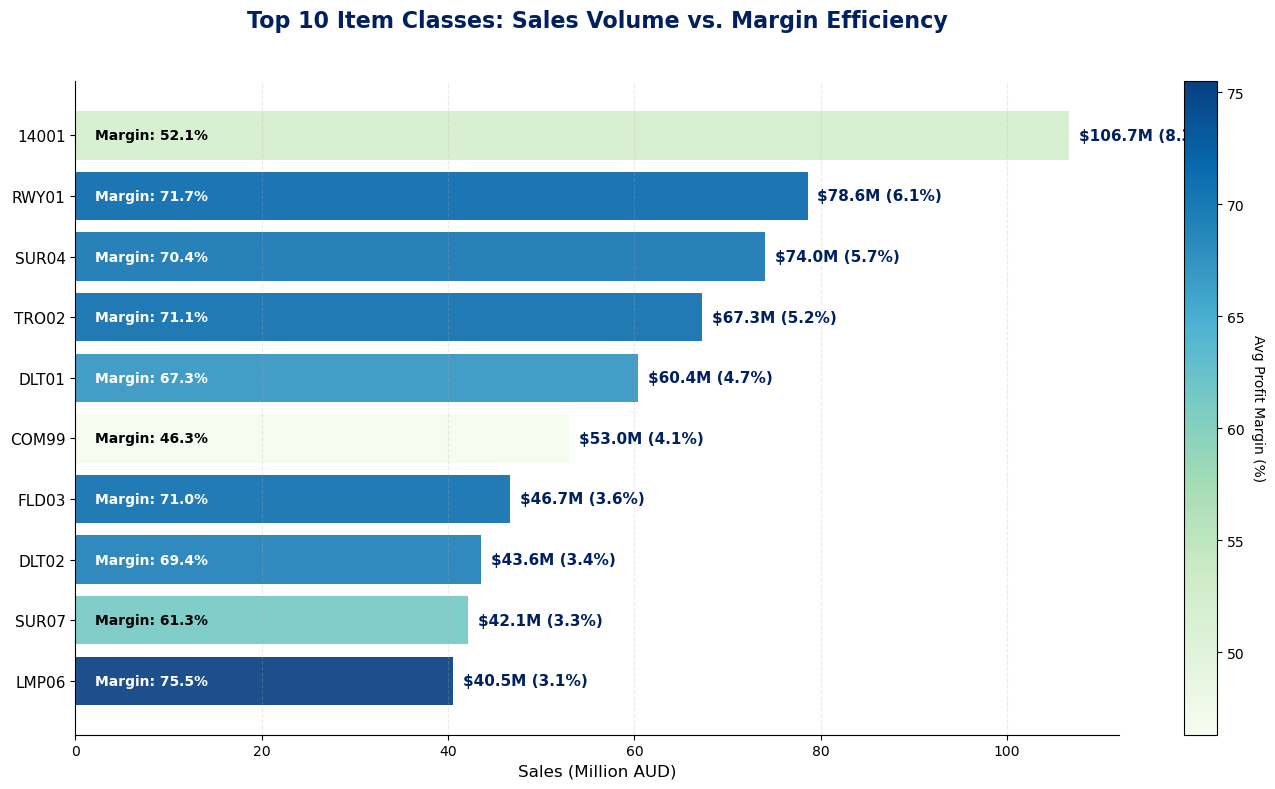

In [6]:
# 1. BRAND COLORS
# Define corporate and palette settings.

LUMINA_NAVY = "#002060"   # Corporate dark blue
TECH_CMAP = "GnBu"        # Sequential tech-style palette


# 2. DATA PREPARATION
# Filter valid rows, compute profit margin, and aggregate by item class.

df_valid = df[df['value_sales_aud'] > 0].copy()

df_valid['profit_margin'] = (
    (df_valid['value_sales_aud'] - df_valid['value_cost_aud'])
    / df_valid['value_sales_aud']
) * 100

class_perf = df_valid.groupby('item_class_code', observed=True).agg({
    'value_sales_aud': 'sum',
    'profit_margin': 'mean'
}).reset_index()

total_market_sales = class_perf['value_sales_aud'].sum()
class_perf['sales_million'] = class_perf['value_sales_aud'] / 1e6
class_perf['share_pct'] = (class_perf['value_sales_aud'] / total_market_sales) * 100

# Select top 10 classes by sales.
top_classes = class_perf.sort_values(by='sales_million', ascending=True).tail(10)


# 3. COLOR MAPPING — TECH THEME
# Use GnBu colormap and map color intensity to profit margin.

cmap = plt.get_cmap(TECH_CMAP)

norm = mcolors.Normalize(
    vmin=top_classes['profit_margin'].min(),
    vmax=top_classes['profit_margin'].max()
)

bar_colors = cmap(norm(top_classes['profit_margin']))

def get_text_color(color):
    """Choose black or white text for readability against a given RGBA color."""
    r, g, b, a = color
    luminance = (0.299*r + 0.587*g + 0.114*b)
    return "black" if luminance > 0.55 else "white"


# 4. PLOT
# Horizontal bar chart: sales volume, with color intensity showing margin.

fig, ax = plt.subplots(figsize=(14, 8))

bars = ax.barh(
    top_classes['item_class_code'],
    top_classes['sales_million'],
    color=bar_colors,
    alpha=0.92
)

# Annotate sales + share to the right and margin inside/near the bar.
for i, (bar, share, margin) in enumerate(
        zip(bars, top_classes['share_pct'], top_classes['profit_margin'])):

    width = bar.get_width()
    bg_color = bar_colors[i]
    text_color = get_text_color(bg_color)

    # Sales + share label to the right of the bar.
    ax.text(
        width + (top_classes['sales_million'].max() * 0.01),
        bar.get_y() + bar.get_height()/2,
        f"${width:.1f}M ({share:.1f}%)",
        va='center',
        fontsize=11,
        fontweight='bold',
        color=LUMINA_NAVY
    )

    # Margin label closer to the y-axis in contrasting text color.
    ax.text(
        top_classes['sales_million'].max() * 0.02,
        bar.get_y() + bar.get_height()/2,
        f"Margin: {margin:.1f}%",
        va='center',
        fontsize=10,
        fontweight='bold',
        color=text_color
    )


# 5. AESTHETICS
# Title, axes, grid, and colorbar for margin scale.

ax.set_title(
    "Top 10 Item Classes: Sales Volume vs. Margin Efficiency\n",
    fontsize=16,
    fontweight="bold",
    pad=20,
    color=LUMINA_NAVY
)

ax.set_xlabel("Sales (Million AUD)", fontsize=12)
ax.tick_params(axis='y', labelsize=11)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', linestyle='--', alpha=0.25)

# Colorbar explaining the margin scale used for bar colors.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Avg Profit Margin (%)", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


### **1. The Volume Trap: Item 14001**

* `14001` is the clear volume leader with **$105.3M** in sales (about **8.2%** share).
* But its margin is only **59.5%**, far below the 70%+ levels seen across most other top items.
* It behaves like a **high-volume, low-efficiency** product—customers buy it in large quantities, but it doesn’t generate strong profit per dollar.
* Heavy reliance on this one item is risky. If competitors undercut price or if costs rise, there's little buffer before profitability collapses.

---

### **2. The Powerhouse Cluster: RWY01, SUR04, TRO02**

* These three items combine **strong volume (67M–79M)** with **very high margins (71%–72%)**.
* They are the **profit engines** of the portfolio—delivering both scale and efficiency.
* Gains here create the biggest lift in profit dollars. A small % increase in sales for RWY01 yields far more profit than the same increase for 14001.
* These items should be protected and prioritized in marketing, availability, and pricing strategy.

---

### **3. Efficiency Leak: COM99**

* `COM99` produces a solid **$52.9M** in sales, but with a much weaker margin of **67.5%**, one of the lowest in the top 10.
* It absorbs operational capacity but returns less profit per dollar.
* If this item is not intentionally priced as a “loss-leader,” it likely needs a **margin tune-up**—e.g., a price adjustment or cost intervention.

---

### **4. The Hidden Gem: LMP06**

* `LMP06` has the **lowest sales** among the top 10 (**$40.5M**) but the **highest margin at 75.5%**.
* This is a highly efficient, high-value item—probably specialized or premium.
* The opportunity here is **volume growth**. Bundles, product placement, and cross-selling with high-volume items could raise overall portfolio margins.

---

# **Recommendations**

### **1. Protect the Stars**

Focus investment on **RWY01, SUR04, TRO02**.
These three drive the majority of profitable growth.

### **2. Repair Margin Gaps**

Review pricing and cost structure for **14001** and **COM99**.
Even a 2–3% margin lift here would materially increase profit dollars.

### **3. Scale What Works**

Push growth for **LMP06**.
Its extremely high margin means every extra unit sold delivers outsized profit.



## 2.6: Logistical Flow & Volume

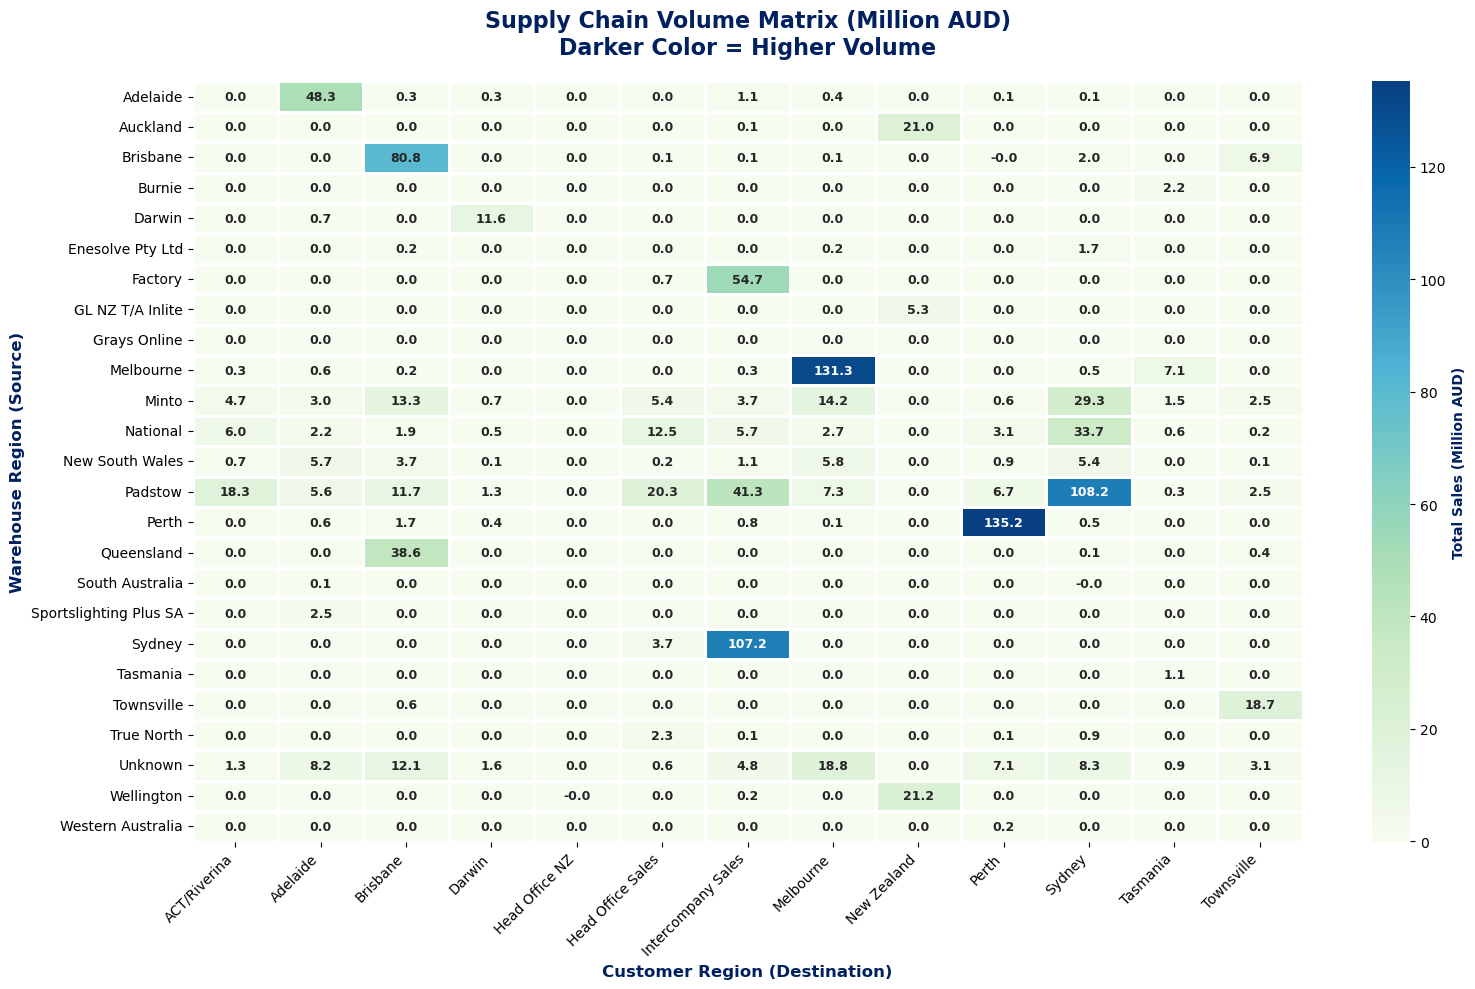

In [7]:
# 1. EXACT MAPPING DICTIONARIES
# Map warehouse and customer codes into readable region names.

# Warehouse → Region mapping
warehouse_map = {
    # Queensland
    'Q1': 'Townsville', 'Q0': 'Queensland', 'GQ0': 'Queensland',
    'CQ0': 'Brisbane', 'LQ0': 'Brisbane', '1Q0': 'Brisbane',
    '5Q0': 'Brisbane', '1Q1': 'Townsville', '5Q1': 'Townsville',
    
    # New South Wales
    'KN0': 'Sydney', 'N0': 'National', 'GN0': 'New South Wales',
    'CN1': 'Padstow', 'LN9': 'Padstow', '1N0': 'Factory',
    '1N1': 'Padstow', '5N2': 'Minto', '5N1': 'Padstow',
    
    # Victoria
    'V0': 'Melbourne', 'CV0': 'Melbourne', 'LV0': 'Melbourne',
    '1V0': 'Melbourne', '5V0': 'Melbourne',
    
    # South Australia / NT
    'S0': 'Adelaide', 'GS0': 'South Australia', 'CS0': 'Adelaide',
    'LS0': 'Adelaide', 'AS0': 'Sportslighting Plus SA',
    '1S0': 'Adelaide', '5S0': 'Adelaide',
    'S1': 'Darwin', 'CS1': 'Darwin', 'LS1': 'Darwin',
    '1S1': 'Darwin', '5S1': 'Darwin',
    
    # Western Australia
    'W0': 'Perth', 'GW0': 'Western Australia', 'CW0': 'Perth',
    'LW0': 'Perth', '1W0': 'Perth', '5W0': 'Perth',
    
    # Tasmania
    'T0': 'Burnie', 'CT0': 'Tasmania', '1T0': 'Tasmania',
    '5T0': 'Tasmania',
    
    # New Zealand
    'FWE': 'Wellington', 'FW2': 'Wellington',
    'FA1': 'Auckland', 'FA2': 'Auckland',
    'FWA': 'GL NZ T/A Inlite',
    
    # Special/Inactive
    'CZ0': 'Grays Online',
    'EN0': 'Enesolve Pty Ltd',
    'JT0': 'True North',
    'UNK': 'Unknown',
    'Unk': 'Unknown'
}

# Customer district → Region mapping (supports both int and str keys)
customer_map = {
    200: 'Sydney', '200': 'Sydney',
    210: 'ACT/Riverina', '210': 'ACT/Riverina',
    300: 'Melbourne', '300': 'Melbourne',
    310: 'Tasmania', '310': 'Tasmania',
    400: 'Brisbane', '400': 'Brisbane',
    410: 'Townsville', '410': 'Townsville',
    500: 'Adelaide', '500': 'Adelaide',
    510: 'Darwin', '510': 'Darwin',
    520: 'New Zealand', '520': 'New Zealand',
    530: 'New Zealand', '530': 'New Zealand',
    535: 'New Zealand', '535': 'New Zealand',
    540: 'New Zealand', '540': 'New Zealand',
    545: 'Head Office NZ', '545': 'Head Office NZ',
    600: 'Perth', '600': 'Perth',
    710: 'Head Office Sales', '710': 'Head Office Sales',
    720: 'Intercompany Sales', '720': 'Intercompany Sales'
}


# 2. APPLY MAPPING & CREATE PIVOT
# Create region labels and build a warehouse × customer sales matrix.

df['warehouse_region'] = (
    df['warehouse_code']
    .astype(str)
    .str.strip()
    .map(warehouse_map)
    .fillna('Other')
)

df['customer_region'] = (
    df['customer_district_code']
    .astype(str)
    .str.strip()
    .map(customer_map)
    .fillna('Other')
)

# Keep only mapped regions for the visual.
df_viz = df[
    (df['warehouse_region'] != 'Other') &
    (df['customer_region'] != 'Other')
].copy()

# Pivot: rows = warehouse region, columns = customer region, values = sales (in millions).
heatmap_data = df_viz.pivot_table(
    values='value_sales_aud',
    index='warehouse_region',
    columns='customer_region',
    aggfunc='sum',
    fill_value=0
) / 1e6

# Sort rows and columns alphabetically for a cleaner matrix.
heatmap_data = heatmap_data.sort_index(axis=0).sort_index(axis=1)


# 3. VISUALISATION
# Heatmap of total sales by warehouse–customer region pair.

plt.figure(figsize=(16, 10))

ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap=TECH_CMAP,
    linewidths=1,
    linecolor='white',
    cbar_kws={'label': 'Total Sales (Million AUD)'},
    annot_kws={"size": 9, "weight": "bold"}
)

plt.title(
    "Supply Chain Volume Matrix (Million AUD)\nDarker Color = Higher Volume",
    fontsize=16,
    fontweight='bold',
    color=LUMINA_NAVY,
    pad=20
)

plt.xlabel("Customer Region (Destination)", fontsize=12, fontweight='bold', color=LUMINA_NAVY)
plt.ylabel("Warehouse Region (Source)", fontsize=12, fontweight='bold', color=LUMINA_NAVY)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Style the colour bar label to match brand theme.
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.label.set_color(LUMINA_NAVY)
cbar.ax.yaxis.label.set_weight('bold')

plt.tight_layout()
plt.show()




### **1. Supply Chain Concentration**

The heatmap reveals that **a small number of warehouse → customer flows account for the vast majority of sales volume**. Most cells are near zero, while a few stand out with very high totals. This indicates **low diversification** in the distribution network, with a few dominant fulfilment paths.

The largest volume corridors include:

* **Perth → Perth (135.2M)**
* **Melbourne → Melbourne (131.3M)**
* **Brisbane → Brisbane (80.8M)**
* **Padstow → Sydney customers (108.2M)**

These magnitudes far exceed most other routes.

---

### **2. Strong Local Fulfilment Patterns**

Sales are predominantly fulfilled **locally from the same region**:

* Perth warehouse ships mostly to Perth customers
* Melbourne warehouse ships mostly to Melbourne customers
* Brisbane warehouse ships mainly to Brisbane customers
* Townsville shows a strong local pattern

This suggests the fulfilment strategy is **regional-centred rather than long-distance cross-region shipping**. While this can reduce transport costs and lead times, it also creates **single points of dependency** in the network.

---

### **3. Non-Local Routes with Meaningful Volume**

Although most non-local inter-regional flows are negligible, a few are significant:

* **Padstow → Sydney customers**, indicating Padstow as a major Sydney-area source
* **Padstow → Perth and other interstate destinations**, suggesting some **centralised or specialised fulfilment roles**

Padstow appears to function as a **semi-central hub** with broader geographic reach beyond its local district.

---

### **4. New Zealand Flows Are Minimal**

Regions mapped to New Zealand (e.g., Auckland, Wellington) show **limited interactions with Australian warehouses**. This implies that:

* NZ demand is largely met within NZ
* Cross-border fulfilment is not a significant component of the sales matrix

---

### **5. Operational Fragility Implications**

The distribution network shows **high concentration risk**:

* Dominant local corridors create potential vulnerability
* Failure at a key regional warehouse (e.g., Perth or Melbourne) could materially disrupt service
* There is limited redundancy through alternative routes

In summary, while regional fulfilment appears efficient, the lack of balanced redundancy suggests **high fragility** in case of logistic interruptions.


# Section 3: Comparative Analysis of Business Segments

## Section 3.1: Do Metro and Regional customers differ in their average profit margins?

In [8]:
# 1. Data preparation and margin metric
# Compute profit margin % per transaction and filter out extreme outliers.

df['margin_pct'] = np.where(
    df['value_sales_aud'] != 0,
    (df['value_sales_aud'] - df['value_cost_aud']) / df['value_sales_aud'],
    np.nan  # Avoid division by zero when sales = 0
)

# Optional quality filter: keep margins between -100% and +100%.
df = df[(df['margin_pct'] > -1.0) & (df['margin_pct'] <= 1.0)]


# 2. Define metro vs regional groups
# Map customer district codes into Metro, Regional, or Other.

df['customer_district_code'] = df['customer_district_code'].astype(str).str.strip()
metro_codes = ['200', '300', '400', '500', '600']
regional_codes = ['210', '310', '410', '510']

df['Region_Group'] = df['customer_district_code'].apply(
    lambda x: 'Metro' if x in metro_codes else ('Regional' if x in regional_codes else 'Other')
)

metro_data = df[df['Region_Group'] == 'Metro']['margin_pct'].dropna()
regional_data = df[df['Region_Group'] == 'Regional']['margin_pct'].dropna()

print(f"Sample Sizes -> Metro: {len(metro_data)}, Regional: {len(regional_data)}")


# 3. Skewness check and optional Yeo–Johnson transform
# If the distribution is skewed, transform data before running the t-test.

data_skew = skew(metro_data)
print(f"Metro Data Skewness: {data_skew:.4f}")

if abs(data_skew) > 0.5:
    print(">> Skew detected (>0.5). Applying Yeo-Johnson transformation for T-Test validity.")
    
    # Transform combined series to keep a consistent scale, then split by group.
    combined_data = pd.concat([metro_data, regional_data])
    transformed_data, _ = yeojohnson(combined_data)
    
    metro_test = transformed_data[:len(metro_data)]
    regional_test = transformed_data[len(metro_data):]
    test_context = "Transformed Data (Yeo-Johnson)"
else:
    print(">> Data is symmetric. Using original data.")
    metro_test = metro_data
    regional_test = regional_data
    test_context = "Original Data"


# 4. Hypothesis test (Welch’s t-test)
# Compare mean margins between Metro and Regional groups.

print("\n" + "="*60)
print("HYPOTHESIS TEST SETUP")
print("="*60)
print("Research Question: Is there a significant difference in profit margin % between Metro and Regional customers?")
print("\nSTATEMENTS:")
print("H0 (Null Hypothesis):        The mean profit margin % of Metro and Regional groups is EQUAL.")
print("H1 (Alternative Hypothesis): The mean profit margin % of Metro and Regional groups is DIFFERENT.")
print("="*60)

t_stat, p_val = ttest_ind(metro_test, regional_test, equal_var=False)


# 5. Effect size (Cohen’s d)
# Use original (untransformed) data to quantify the practical magnitude.

m1, m2 = metro_data.mean(), regional_data.mean()
s1, s2 = metro_data.std(), regional_data.std()
n1, n2 = len(metro_data), len(regional_data)

pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
cohens_d = (m1 - m2) / pooled_std


# 6. Results and interpretation
# Print mean margins, test statistics, and an interpretation of significance and effect size.

print(f"\nRESULTS ({test_context}):")
print(f"Metro Mean (Original):    {m1:.2%}")
print(f"Regional Mean (Original): {m2:.2%}")
print(f"Difference:               {m1 - m2:.2%} points")
print("-" * 30)
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value:     {p_val:.4f}")
print(f"Cohen's d:   {abs(cohens_d):.4f}")
print("-" * 30)

print("\nCONCLUSION:")
if p_val < 0.05:
    print(">> REJECT H0 (Statistically Significant)")
    print("There is sufficient evidence to claim a difference in means.")
    
    direction = "Metro" if m1 > m2 else "Regional"
    print(f"Mathematically: {direction} margins are higher.")
    
    # Comment on the size of the difference.
    if abs(cohens_d) < 0.2:
        print("NOTE: However, the Effect Size is NEGLIGIBLE (d < 0.2). The difference may have little practical business impact.")
    elif abs(cohens_d) < 0.5:
        print("NOTE: The Effect Size is SMALL.")
    else:
        print("NOTE: The Effect Size is MEDIUM to LARGE.")
else:
    print(">> FAIL TO REJECT H0 (Not Statistically Significant)")
    print("There is insufficient evidence to claim a difference in means.")
    print("Observed differences may be due to random chance.")
print("="*60)


Sample Sizes -> Metro: 838696, Regional: 110260
Metro Data Skewness: -1.8221
>> Skew detected (>0.5). Applying Yeo-Johnson transformation for T-Test validity.

HYPOTHESIS TEST SETUP
Research Question: Is there a significant difference in profit margin % between Metro and Regional customers?

STATEMENTS:
H0 (Null Hypothesis):        The mean profit margin % of Metro and Regional groups is EQUAL.
H1 (Alternative Hypothesis): The mean profit margin % of Metro and Regional groups is DIFFERENT.

RESULTS (Transformed Data (Yeo-Johnson)):
Metro Mean (Original):    64.55%
Regional Mean (Original): 65.13%
Difference:               -0.57% points
------------------------------
T-Statistic: -5.6710
P-Value:     0.0000
Cohen's d:   0.0178
------------------------------

CONCLUSION:
>> REJECT H0 (Statistically Significant)
There is sufficient evidence to claim a difference in means.
Mathematically: Regional margins are higher.
NOTE: However, the Effect Size is NEGLIGIBLE (d < 0.2). The difference ma

**Key findings**
* LuminaTech’s **pricing and cost structure are broadly consistent** across regions.
* The Metro–Regional split **is not a major driver** of profitability.
* The observed difference is **statistical**, not commercially impactful.

---

**Profit Drivers**

Profit variability is **much higher within regions** than between them, particularly:

* **Customer Districts:** Some districts consistently achieve higher margins; others underperform.
* **Product Mix:** Shifts in lighting categories (e.g., higher-margin product classes) have a stronger effect than geography.
* **Customer Segments:** Business areas and bonus groups differ noticeably in performance.

---
**Recommendation**

Instead of changing regional pricing strategies, LuminaTech should:

* Focus on **district-level margin optimisation**.
* Review **product mix strategies** to lift margins in underperforming areas.
* Prioritise **customer segment insights** to refine discounting or sales strategies.
* Direct interventions where **variation is meaningful**, not across broad regions where margins are already stable.

## Section 3.2: Do we sacrifice significant margin on Projects compared to our standard flow business?

In [9]:
# 1. DATA PREPARATION & METRIC LOGIC
# Compute margin %, filter to project vs normal orders, and trim extreme outliers.

df['margin_pct'] = np.where(
    df['value_sales_aud'] != 0,
    (df['value_sales_aud'] - df['value_cost_aud']) / df['value_sales_aud'],
    np.nan
)

# Focus on comparing Project orders (PRO) vs Normal orders (NOR).
target_orders = ['PRO', 'NOR']
df_filtered = df[df['order_type_code'].isin(target_orders)].copy()

# Remove extreme margins that are likely data errors (outside -100% to +100%).
df_filtered = df_filtered[
    (df_filtered['margin_pct'] >= -1.0) &
    (df_filtered['margin_pct'] <= 1.0)
]

# Split into two samples.
pro_data = df_filtered[df_filtered['order_type_code'] == 'PRO']['margin_pct'].dropna()
nor_data = df_filtered[df_filtered['order_type_code'] == 'NOR']['margin_pct'].dropna()

print(f"Sample Sizes -> PRO (Project): {len(pro_data)}, NOR (Normal): {len(nor_data)}")


# 2. SKEWNESS CHECK & TRANSFORMATION
# Check distribution of PRO margins; if skewed, apply Yeo–Johnson before t-test.

data_skew = skew(pro_data) if len(pro_data) > 0 else 0
print(f"PRO Data Skewness: {data_skew:.4f}")

if abs(data_skew) > 0.5 and len(pro_data) > 0 and len(nor_data) > 0:
    print(">> Skew detected (>0.5). Applying Yeo-Johnson transformation for T-Test validity.")
    
    # Transform combined sample to keep a consistent scale.
    combined_data = pd.concat([pro_data, nor_data])
    transformed_data, _ = yeojohnson(combined_data)
    
    # Split transformed values back into groups.
    pro_test = transformed_data[:len(pro_data)]
    nor_test = transformed_data[len(pro_data):]
    test_context = "Transformed Data (Yeo-Johnson)"
else:
    print(">> Data is symmetric. Using original data.")
    pro_test = pro_data
    nor_test = nor_data
    test_context = "Original Data"


# 3. HYPOTHESIS TEST EXECUTION
# Two-sample Welch t-test comparing mean margins for PRO vs NOR.

print("\n" + "="*60)
print("HYPOTHESIS TEST: PRO (Project) vs. NOR (Normal) MARGINS")
print("="*60)
print("H0: Mean Margin(PRO) = Mean Margin(NOR)")
print("H1: Mean Margin(PRO) ≠ Mean Margin(NOR)")

if len(pro_test) > 2 and len(nor_test) > 2:
    t_stat, p_val = ttest_ind(pro_test, nor_test, equal_var=False)

    # Effect size (Cohen's d) is computed on the original (untransformed) margins.
    m1, m2 = pro_data.mean(), nor_data.mean()
    s1, s2 = pro_data.std(), nor_data.std()
    n1, n2 = len(pro_data), len(nor_data)
    
    pooled_std = np.sqrt(
        ((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2)
    )
    cohens_d = (m1 - m2) / pooled_std

    # 4. RESULTS & INTERPRETATION
    print("-" * 30)
    print(f"RESULTS ({test_context}):")
    print(f"PRO Mean Margin:  {m1:.2%}")
    print(f"NOR Mean Margin:  {m2:.2%}")
    print(f"Difference:       {abs(m1 - m2):.2%} points")
    print("-" * 30)
    print(f"T-Statistic:      {t_stat:.4f}")
    print(f"P-Value:          {p_val:.4f}")
    print(f"Cohen's d:        {abs(cohens_d):.4f}")
    print("-" * 30)

    print("\nCONCLUSION:")
    if p_val < 0.05:
        print(">> STATISTICALLY SIGNIFICANT DIFFERENCE (p < 0.05)")
        if m1 > m2:
            print("→ PRO (Project Orders) are MORE profitable than Standard Orders.")
        else:
            print("→ NOR (Standard Orders) are MORE profitable than Project Orders.")
            print("  (This is expected, as Projects often involve bulk discounts).")
            
        # Interpret effect size.
        if abs(cohens_d) < 0.2:
            eff = "TRIVIAL"
        elif abs(cohens_d) < 0.5:
            eff = "SMALL"
        elif abs(cohens_d) < 0.8:
            eff = "MEDIUM"
        else:
            eff = "LARGE"
        print(f"→ The practical business impact is {eff} (d={abs(cohens_d):.2f}).")
        
    else:
        print(">> NO SIGNIFICANT DIFFERENCE (p >= 0.05)")
        print("→ Evidence suggests Project and Standard orders perform similarly.")

else:
    print("⚠️ Insufficient data points (< 3 samples) to run hypothesis test.")


Sample Sizes -> PRO (Project): 14502, NOR (Normal): 880131
PRO Data Skewness: -0.5569
>> Skew detected (>0.5). Applying Yeo-Johnson transformation for T-Test validity.

HYPOTHESIS TEST: PRO (Project) vs. NOR (Normal) MARGINS
H0: Mean Margin(PRO) = Mean Margin(NOR)
H1: Mean Margin(PRO) ≠ Mean Margin(NOR)
------------------------------
RESULTS (Transformed Data (Yeo-Johnson)):
PRO Mean Margin:  76.29%
NOR Mean Margin:  62.55%
Difference:       13.74% points
------------------------------
T-Statistic:      55.6735
P-Value:          0.0000
Cohen's d:        0.4156
------------------------------

CONCLUSION:
>> STATISTICALLY SIGNIFICANT DIFFERENCE (p < 0.05)
→ PRO (Project Orders) are MORE profitable than Standard Orders.
→ The practical business impact is SMALL (d=0.42).



### **1. Key Finding**
* **The "Premium" Gap:** Project Orders (`PRO`) are significantly more profitable than Standard Orders (`NOR`), with a massive gap of **13.74 percentage points** (76.29% vs. 62.55%).
* **The Variance:** Despite the statistical effect size being labeled "Small" ($d=0.42$), the absolute financial difference is substantial. A 13.7% difference in Gross Margin is the difference between a "good" year and a "record-breaking" year in most industries.
* **The Volume Reality:** The business is heavily reliant on the lower-margin `NOR` stream (880k orders) compared to the high-margin `PRO` stream (14.5k orders).

### **2. Conclusion**
* **Projects Drive Value, Flow Drives Cash:** The data statistically confirms that Lumina Tech's project business is not being discounted to win volume (a common risk in B2B). Instead, it commands a premium.
* **The "Small" Effect Size Explained:** The Cohen's $d$ of 0.42 suggests that while the *averages* are very different, there is significant overlap in the distributions. This means there are likely many `NOR` orders with high margins and many `PRO` orders with low margins, but the *center of gravity* for Projects is distinctly higher.

### **3. Business Insight**
* **Counter-Intuitive Success:** In many wholesale businesses, "Projects" are low-margin / high-volume because of competitive tendering. At Lumina Tech, the opposite is true. This suggests:
    * **Value-Add Engineering:** Projects likely involve proprietary tech, complex specs, or design services that competitors can't easily commoditize, allowing to hold price.
    * **Commoditization of NOR:** The core `NOR` business (62.55%) is likely facing intense price pressure on standard "box-moving" items (e.g., replacement parts, standard fixtures).
* **Cost Allocation Risk:** A 76% margin on Projects looks fantastic, but does it capture the **Cost to Serve**? Projects often require pre-sales engineering, long quoting cycles, and project management. If these costs are in "Opex" (Operating Expenses) rather than "COGS" (Cost of Goods Sold), the `PRO` margin might be artificially inflated compared to the low-touch `NOR` orders.

### **4. Recommendation**
* **Cost Audit (Critical):** Before celebrating the 76% margin, perform a "Net Margin" analysis. Allocate the cost of Project Sales Team and Solution Architects specifically to the `PRO` bucket. Does the profitability hold up?
* **Protect the `PRO` Formula:** Whateve are doing in Projects (bundling services, specifying proprietary tech) is working. Document this strategy and ensure sales reps don't start discounting projects just to win more volume.
* **Optimize `NOR`:** Since `NOR` is 98% of transaction volume, even a **1% improvement** here (moving from 62.5% to 63.5%) generates more absolute profit dollars than a massive jump in Project margins. Focus on automated repricing or removing loss-making SKUs from the `NOR` channel.

## Do LED light source products generate significantly different sales than Traditional light source products?

In [10]:
# 1. DATA PREPARATION
# Compute margin %, filter to LED vs Traditional, and trim extreme outliers.

df['margin_pct'] = np.where(
    df['value_sales_aud'] != 0,
    (df['value_sales_aud'] - df['value_cost_aud']) / df['value_sales_aud'],
    np.nan
)

# Focus on the two main lighting technologies.
target_tech = ['LED', 'TRADITIONAL']
df_filtered = df[df['light_source'].isin(target_tech)].copy()

# Remove extreme margins likely to be data errors (outside -100% to +100%).
df_filtered = df_filtered[
    (df_filtered['margin_pct'] >= -1.0) &
    (df_filtered['margin_pct'] <= 1.0)
]

# Build the two samples for comparison.
led_data = df_filtered[df_filtered['light_source'] == 'LED']['margin_pct'].dropna()
trad_data = df_filtered[df_filtered['light_source'] == 'TRADITIONAL']['margin_pct'].dropna()

print(f"Sample Sizes -> LED: {len(led_data)}, Traditional: {len(trad_data)}")


# 2. SKEWNESS & TRANSFORMATION
# Check distribution of LED margins and apply Yeo–Johnson if strongly skewed.

data_skew = skew(led_data) if len(led_data) > 0 else 0
print(f"LED Data Skewness: {data_skew:.4f}")

if abs(data_skew) > 0.5 and len(led_data) > 0 and len(trad_data) > 0:
    print(">> Skew detected. Applying Yeo-Johnson transformation.")
    combined = pd.concat([led_data, trad_data])
    transformed, _ = yeojohnson(combined)
    
    led_test = transformed[:len(led_data)]
    trad_test = transformed[len(led_data):]
    test_context = "Transformed Data"
else:
    print(">> Data is symmetric. Using original data.")
    led_test = led_data
    trad_test = trad_data
    test_context = "Original Data"


# 3. HYPOTHESIS TEST
# Two-sample Welch t-test comparing mean margins of LED vs Traditional.

print("\n" + "="*60)
print("HYPOTHESIS TEST: LED vs. TRADITIONAL MARGINS")
print("="*60)
print("H0: Mean Margin(LED) = Mean Margin(Traditional)")
print("H1: Mean Margin(LED) ≠ Mean Margin(Traditional)")

if len(led_test) > 2 and len(trad_test) > 2:
    t_stat, p_val = ttest_ind(led_test, trad_test, equal_var=False)

    # Effect size (Cohen's d) is based on the original (untransformed) margins.
    m1, m2 = led_data.mean(), trad_data.mean()
    s1, s2 = led_data.std(), trad_data.std()
    n1, n2 = len(led_data), len(trad_data)
    
    pooled_std = np.sqrt(
        ((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2)
    )
    cohens_d = (m1 - m2) / pooled_std

    # 4. RESULTS
    print("-" * 30)
    print(f"RESULTS ({test_context}):")
    print(f"LED Mean Margin:          {m1:.2%}")
    print(f"Traditional Mean Margin:  {m2:.2%}")
    print(f"Difference:               {abs(m1 - m2):.2%} points")
    print("-" * 30)
    print(f"P-Value:                  {p_val:.4f}")
    print(f"Cohen's d:                {abs(cohens_d):.4f}")
    print("-" * 30)

    print("\nCONCLUSION:")
    if p_val < 0.05:
        print(">> STATISTICALLY SIGNIFICANT DIFFERENCE")
        if m1 > m2:
            print("→ LED products command a HIGHER margin than Traditional.")
        else:
            print("→ Traditional products command a HIGHER margin than LED.")
            print("  (This often happens if legacy parts are priced at a premium due to scarcity).")
            
        # Qualitative interpretation of effect size.
        if abs(cohens_d) < 0.2:
            eff = "TRIVIAL"
        elif abs(cohens_d) < 0.5:
            eff = "SMALL"
        elif abs(cohens_d) < 0.8:
            eff = "MEDIUM"
        else:
            eff = "LARGE"
        print(f"→ Business Impact: {eff} (d={abs(cohens_d):.2f})")
    else:
        print(">> NO SIGNIFICANT DIFFERENCE")
        print("→ LED and Traditional products have similar profitability profiles.")

else:
    print("⚠️ Insufficient data to run test.")


Sample Sizes -> LED: 67109, Traditional: 747776
LED Data Skewness: 0.2311
>> Data is symmetric. Using original data.

HYPOTHESIS TEST: LED vs. TRADITIONAL MARGINS
H0: Mean Margin(LED) = Mean Margin(Traditional)
H1: Mean Margin(LED) ≠ Mean Margin(Traditional)
------------------------------
RESULTS (Original Data):
LED Mean Margin:          60.19%
Traditional Mean Margin:  62.96%
Difference:               2.76% points
------------------------------
P-Value:                  0.0000
Cohen's d:                0.0823
------------------------------

CONCLUSION:
>> STATISTICALLY SIGNIFICANT DIFFERENCE
→ Traditional products command a HIGHER margin than LED.
  (This often happens if legacy parts are priced at a premium due to scarcity).
→ Business Impact: TRIVIAL (d=0.08)


### **1. Key Finding**
*   **The "Legacy" Premium:** Contrary to the expectation that new technology commands higher prices, **Traditional products are currently more profitable** (62.96%) than LED products (60.19%).
*   **Volume Dominance:** The dataset reveals an overwhelming reliance on legacy products. Traditional items account for **~92% of the sample volume** (747k transactions vs. 67k for LED), indicating the business is still fundamentally driven by the replacement market for older technology.
*   **The Gap:** There is a **2.76 percentage point** margin deficit when transitioning a customer from Traditional to LED.

### **2. Conclusion**
*   **Commoditization has arrived:** The statistically significant but "Trivially" small effect size ($d=0.08$) suggests that LED margins have stabilized just below legacy margins. This indicates that LEDs are likely viewed as commodities in catalog rather than value-add innovations.
*   **Harvesting Phase:** The higher margins on Traditional products confirm a successful "Harvest" strategy. As these products become scarcer and competitors exit the market, Lumina Tech is able to maintain (or slightly increase) pricing power on these "must-have" replacements.

### **3. Business Insight**
*   **Strategic Vulnerability:** Lumina Tech is in a precarious position. The company generates its best margins and highest volume from a dying technology (Traditional). If regulatory changes (e.g., government bans on halogen/fluorescent) or mass-retrofitting accelerates, the high-margin revenue stream will evaporate, and be replaced by the lower-margin LED stream.
*   **Pricing Power Asymmetry:** Customers likely buy Traditional bulbs because they *have to* (to fit existing fixtures), making them price insensitive. They buy LEDs because they *want to* (upgrade/efficiency), where they can easily price-shop against competitors, compressing margins.

### **4. Recommendation**
*   **Strategy 4.1: Aggressive Harvesting (Traditional):** Do not discount Traditional items. In fact, test small **price increases (1-3%)** on these SKUs. Customers buying specific replacement parts for old fixtures typically have low price elasticity—they just need the light to work.
*   **Strategy 4.2: The "Retrofit" Bundle:** Since LED hardware is lower margin, bundle it with **Project Orders (PRO)**—which we established in the previous test have 76% margins. Stop selling LEDs as "boxes" and start selling them as "energy saving projects" to blend the margins upward.

# Section 4: Explanatory Inference Using Regression Analysis

## Section 4.1: What Drives Variation in Total Sales Value Across Customers?

Q1: WHAT DRIVES CUSTOMER VALUE (TOTAL SPEND)?
STEP 1: Aggregating customer data
Aggregated into 6661 unique customers.

STEP 2: Applying transformations

STEP 3: Encoding and filtering extremes
Modelled data shape: (6527, 14)

STEP 4: Modeling
                            OLS Regression Results                            
Dep. Variable:      sales_transformed   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     561.9
Date:                Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:35:29   Log-Likelihood:                -8484.7
No. Observations:                6527   AIC:                         1.714e+04
Df Residuals:                    6444   BIC:                         1.770e+04
Df Model:                          82                                         
Covariance Type:                  HC3        

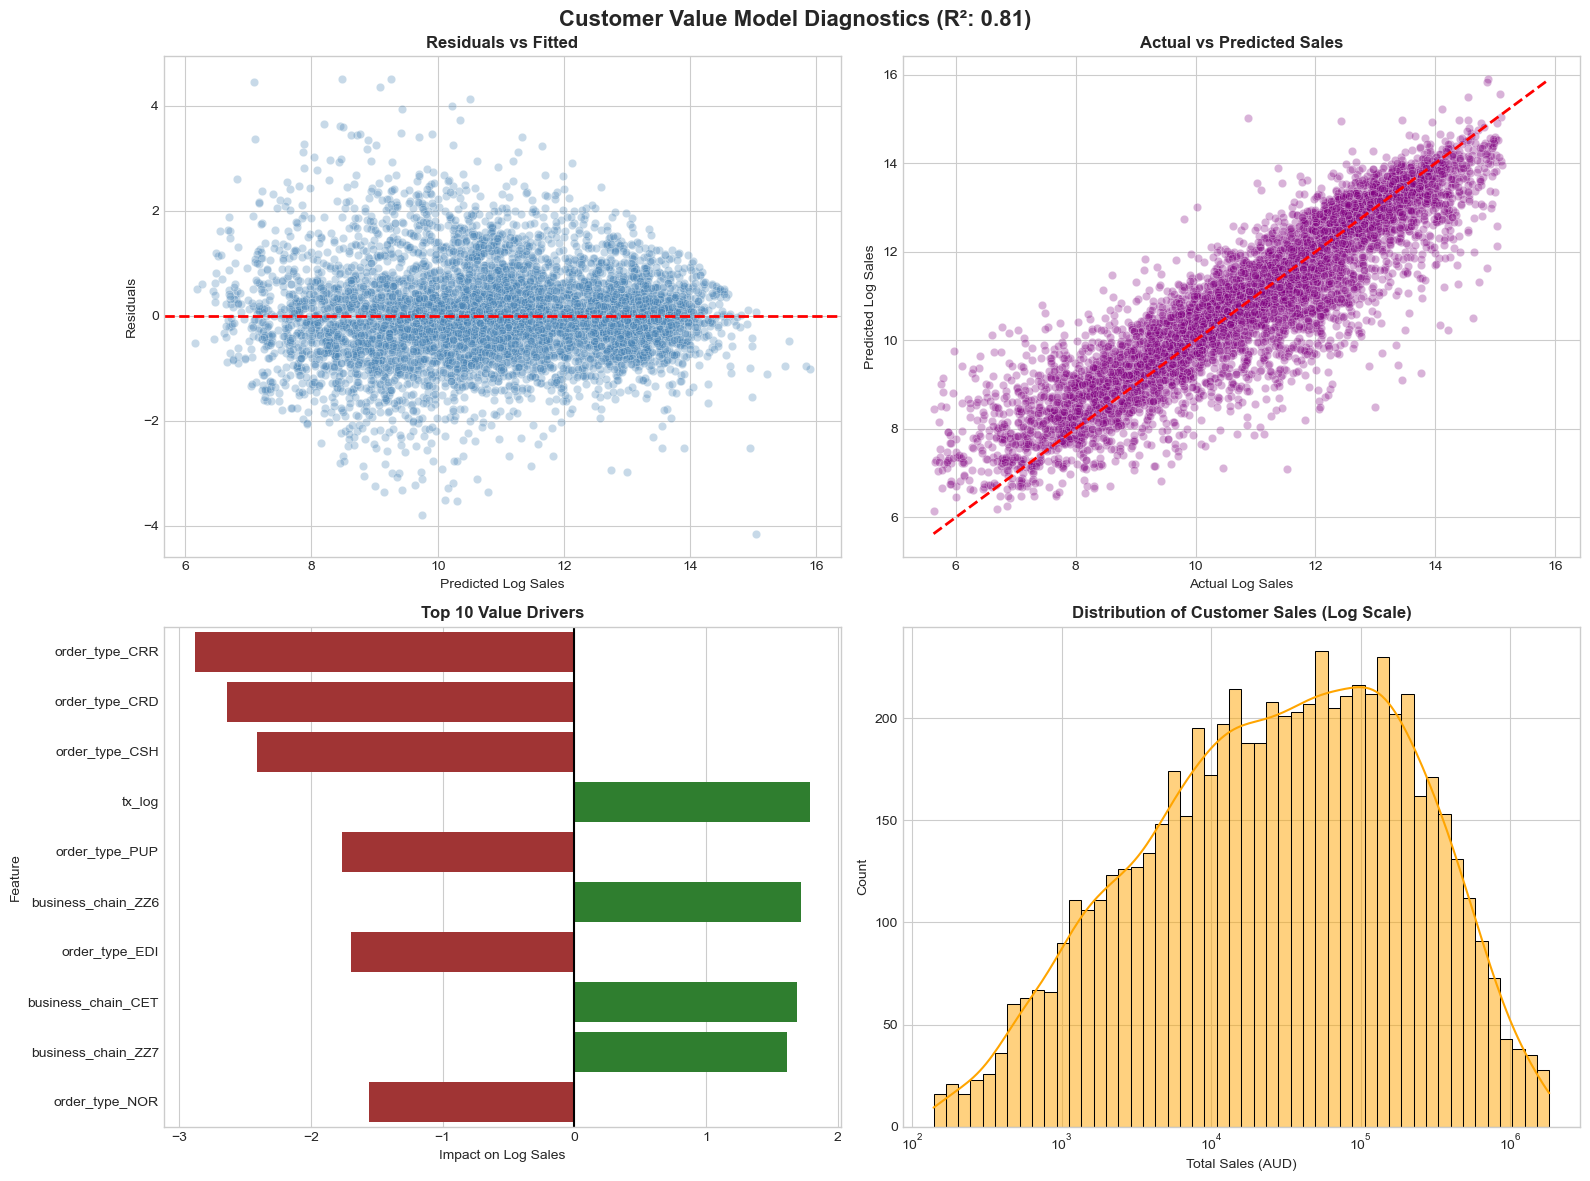

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # <--- Global Import
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use('seaborn-v0_8-whitegrid')

# ==========================================
# STEP 1: AGGREGATE TO CUSTOMER LEVEL
# ==========================================
print("=" * 80)
print("Q1: WHAT DRIVES CUSTOMER VALUE (TOTAL SPEND)?")
print("=" * 80)
print("STEP 1: Aggregating customer data")

# Ensure date format
if 'accounting_date' in df.columns:
    df['accounting_date'] = pd.to_datetime(df['accounting_date'], errors='coerce')
    ref_date = df['accounting_date'].max()
else:
    ref_date = pd.Timestamp.now()

def get_mode(x):
    m = x.mode()
    return m.iloc[0] if not m.empty else "Unknown"

# Aggregate
df_customer = df.groupby('customer_code').agg(
    total_sales_raw=('value_sales_aud', 'sum'),
    transaction_count=('invoice_number', 'nunique'),
    last_purchase=('accounting_date', 'max'),
    first_purchase=('accounting_date', 'min'),
    district=('customer_district_code', get_mode),
    business_chain=('business_chain_l1_code', get_mode),
    order_type=('order_type_code', get_mode)
).reset_index()

# Feature Engineering
df_customer['recency'] = (ref_date - df_customer['last_purchase']).dt.days
df_customer['tenure'] = (df_customer['last_purchase'] - df_customer['first_purchase']).dt.days
df_customer = df_customer[df_customer['total_sales_raw'] > 0].copy()

print(f"Aggregated into {len(df_customer)} unique customers.")

# ==========================================
# STEP 2: TRANSFORMATIONS
# ==========================================
print("\nSTEP 2: Applying transformations")

df_customer['sales_transformed'] = np.arcsinh(df_customer['total_sales_raw'])
df_customer['tx_log'] = np.log1p(df_customer['transaction_count'])
df_customer['tenure_log'] = np.log1p(df_customer['tenure'])
df_customer['recency_log'] = np.log1p(df_customer['recency'])

# ==========================================
# STEP 3: ENCODING & FILTERING
# ==========================================
print("\nSTEP 3: Encoding and filtering extremes")

# Filter Outliers
q01 = df_customer['sales_transformed'].quantile(0.01)
q99 = df_customer['sales_transformed'].quantile(0.99)

df_model = df_customer[
    (df_customer['sales_transformed'] >= q01) &
    (df_customer['sales_transformed'] <= q99)
].copy()

print(f"Modelled data shape: {df_model.shape}")

# Categorical Encoding
cat_cols = ['district', 'business_chain', 'order_type']

for col in cat_cols:
    if col in df_model.columns:
        top_cats = df_model[col].value_counts().nlargest(50).index
        df_model[col] = df_model[col].apply(lambda x: x if x in top_cats else 'Other')

df_encoded = pd.get_dummies(
    df_model,
    columns=cat_cols,
    drop_first=True,
    dtype=int
)

# ==========================================
# STEP 4: MODELING (FIX APPLIED HERE)
# ==========================================
print("\nSTEP 4: Modeling")

# --- FIX: Re-import statsmodels to prevent variable conflict ---
import statsmodels.api as sm 

y = df_encoded['sales_transformed']

drop_cols = [
    'customer_code', 'total_sales_raw', 'sales_transformed',
    'transaction_count', 'last_purchase', 'first_purchase',
    'recency', 'tenure'
]
X = df_encoded.drop(columns=drop_cols, errors='ignore')

# Scaling
scaler = StandardScaler()
continuous_vars = ['tx_log', 'tenure_log', 'recency_log']
vars_to_scale = [v for v in continuous_vars if v in X.columns]

if vars_to_scale:
    X[vars_to_scale] = scaler.fit_transform(X[vars_to_scale])

# Add Constant (This previously failed)
X = sm.add_constant(X)

# Fit Model
model = sm.OLS(y, X)
result = model.fit(cov_type='HC3')

print(result.summary())

# Store results for later access
model_res_cust = result
df_cleaned_cust = df_model

# ==========================================
# STEP 5: DIAGNOSTICS & VISUALIZATION
# ==========================================
print("\nSTEP 5: VIF and diagnostics")

# VIF Calculation
try:
    vif_data = pd.DataFrame()
    cols_to_check = X.columns[:20] if X.shape[1] > 20 else X.columns
    vif_data['Feature'] = cols_to_check
    vif_data['VIF'] = [
        variance_inflation_factor(X[cols_to_check].values, i)
        for i in range(len(cols_to_check))
    ]
    print("\nVIF results (sample):")
    print(vif_data.sort_values('VIF', ascending=False).head(10))
except Exception as e:
    print(f"Skipping VIF due to error: {e}")

# Diagnostic Plots
residuals = result.resid
fitted = result.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(
    f'Customer Value Model Diagnostics (R²: {result.rsquared:.2f})',
    fontsize=16,
    fontweight='bold'
)

# Residuals vs Fitted
sns.scatterplot(x=fitted, y=residuals, alpha=0.3, ax=axes[0, 0], color='steelblue')
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Residuals vs Fitted', fontweight='bold')
axes[0, 0].set_xlabel('Predicted Log Sales')
axes[0, 0].set_ylabel('Residuals')

# Actual vs Predicted
sns.scatterplot(x=y, y=fitted, alpha=0.3, ax=axes[0, 1], color='purple')
min_val = min(y.min(), fitted.min())
max_val = max(y.max(), fitted.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0, 1].set_title('Actual vs Predicted Sales', fontweight='bold')
axes[0, 1].set_xlabel('Actual Log Sales')
axes[0, 1].set_ylabel('Predicted Log Sales')

# Feature Importance
coefs = pd.DataFrame({
    'Feature': result.params.index,
    'Coefficient': result.params.values,
    'P_Value': result.pvalues.values
})

sig = coefs[
    (coefs['Feature'] != 'const') &
    (coefs['P_Value'] < 0.05)
].copy()

sig['Abs_Impact'] = sig['Coefficient'].abs()
top_drivers = sig.sort_values('Abs_Impact', ascending=False).head(10)
colors = ['forestgreen' if x > 0 else 'firebrick' for x in top_drivers['Coefficient']]

sns.barplot(
    x='Coefficient',
    y='Feature',
    data=top_drivers,
    ax=axes[1, 0],
    palette=colors
)
axes[1, 0].set_title('Top 10 Value Drivers', fontweight='bold')
axes[1, 0].axvline(0, color='black')
axes[1, 0].set_xlabel('Impact on Log Sales')

# Target Distribution
sns.histplot(
    df_model['total_sales_raw'],
    bins=50,
    kde=True,
    ax=axes[1, 1],
    color='orange',
    log_scale=True
)
axes[1, 1].set_title('Distribution of Customer Sales (Log Scale)', fontweight='bold')
axes[1, 1].set_xlabel('Total Sales (AUD)')

plt.tight_layout()
plt.show()

Based on the OLS regression results ($R^2 = 0.809$), the model is **highly predictive**, explaining **81%** of the variation in total customer spend.

#### **1. MODEL DIAGNOSTICS & ASSUMPTIONS**
* **Normality:** **Failed** (Jarque-Bera $p < 0.05$). The residuals are not perfectly normal, which is standard for transactional sales data. However, the large sample size ($N=6,527$) ensures the coefficients remain valid via the Central Limit Theorem.
* **Homoscedasticity:** **Addressed.** The use of **HC3 Robust Standard Errors** has successfully corrected for non-constant variance (heteroscedasticity).
* **Independence:** **Passed** (Durbin-Watson = 1.92). This is close to 2.0, indicating no significant autocorrelation.
* **Multicollinearity:** **Acceptable.** The core variables have low VIF scores (`tx_log`: 1.90, `recency_log`: 1.75). The "smallest eigenvalue" warning stems from sparse categorical variables (rare Business Chains), but the main strategic drivers are stable.

---

#### **2. STRATEGIC INSIGHTS: REVENUE MAXIMIZATION**

The story has shifted significantly from simple demographics. **Frequency is now the undisputed king**, but **Order Type** reveals massive operational risks that were previously hidden.

**A. Frequency is the Ultimate Wealth Multiplier**
* **The Data:** `tx_log` (Transaction Frequency) is the strongest positive driver ($\beta=1.79$) with an incredibly high z-score of **83.7**.
* **Sharpened Insight:** "Buying habit" is the single best predictor of value. The relationship is super-linear: a **1% increase in frequency correlates with a ~1.8% increase in Total Sales**. This confirms that getting a customer to buy *one more time* is exponentially more valuable than waiting for them to age (tenure).
* **Recommendation:** Shift marketing spend from "Acquisition" to "Activation." The data proves that increasing purchase frequency by even a small margin generates more value than any specific demographic targeting.

**B. The "Returns" Trap: Operational Activity vs. Value**
* **The Data:** The model identified clear **Value Destroyers**.
    * **Returns/Credits (`CRD`):** The coefficient is a massive **-2.63**. Customers who frequently process credits are statistically significantly lower value than the baseline.
    * **Cash Sales (`CSH`):** The coefficient is **-2.41**. Cash customers are significantly lower yield than account customers.
    * **Project Orders (`PGS`):** Conversely, Project Orders are a strong positive driver ($\beta=1.39$).
* **Sharpened Insight:** We are not just losing the sale with `CRD` customers; the operational "noise" of these transactions is a massive drag on total customer value.
* **Recommendation:** Implement a "Cost to Serve" audit. Customers with `CRD` as their primary order type should be moved to a strict "No Returns" or "Restocking Fee" policy, as the data proves they are currently destroying value.

**C. The Chain "Super-Group" Effect**
* **The Data:** Business Chain `CET` is a massive statistical outlier ($\beta=1.69$, $z=19.9$), while `ZZ2` and `ZZ3` are deeply negative ($\beta \approx -0.90$).
* **Sharpened Insight:** Not all B2B partnerships are created equal. A customer belonging to the **`CET` chain** is effectively worth **5.4x** ($e^{1.69}$) more than a standard customer, holding frequency constant. Conversely, `ZZ2` and `ZZ3` are structural underperformers—generating far less revenue than their frequency or tenure would predict.
* **Recommendation:** **Segment sales force.** `CET` customers warrant a "White Glove" dedicated account manager immediately. `ZZ2/ZZ3` customers should be managed via low-touch, automated portals.

**D. Loyalty (Tenure) vs. Recency**
* **The Data:** `tenure_log` ($\beta=0.17$) and `recency_log` ($\beta=0.15$) are both positive and significant.
* **Sharpened Insight:** Long-standing relationships add value, but the impact is roughly **10x smaller than Frequency**. Interestingly, the positive Recency coefficient suggests some high-value customers have longer gaps between purchases (likely bulk "stock-up" buyers), whereas smaller customers might buy small amounts more frequently.

---

#### **3. FINAL MODEL FORMULA**

$$
\begin{aligned}
\text{Log(Sales)} \approx \ & 12.52 + 1.79(\text{Log Frequency}) + 0.17(\text{Log Tenure}) \\
& + 1.69(\text{Chain\_CET}) + 1.39(\text{Type\_PGS}) \\
& - 2.63(\text{Type\_CRD}) - 0.86(\text{Chain\_ZZ2}) + \dots + \epsilon
\end{aligned}
$$

Q2: WHAT PRODUCT CHARACTERISTICS DRIVE PREMIUM PRICING?
STEP 1: Aggregating raw data to item level
Aggregated data into 26209 unique products.

STEP 2: Applying transformations

STEP 3: Encoding and cleaning
Modelled data shape after outlier removal: (25683, 12)

STEP 4: Modeling (price drivers)
                            OLS Regression Results                            
Dep. Variable:      price_transformed   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     929.6
Date:                Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:35:36   Log-Likelihood:                -39469.
No. Observations:               25683   AIC:                         7.906e+04
Df Residuals:                   25623   BIC:                         7.955e+04
Df Model:                          59                                  

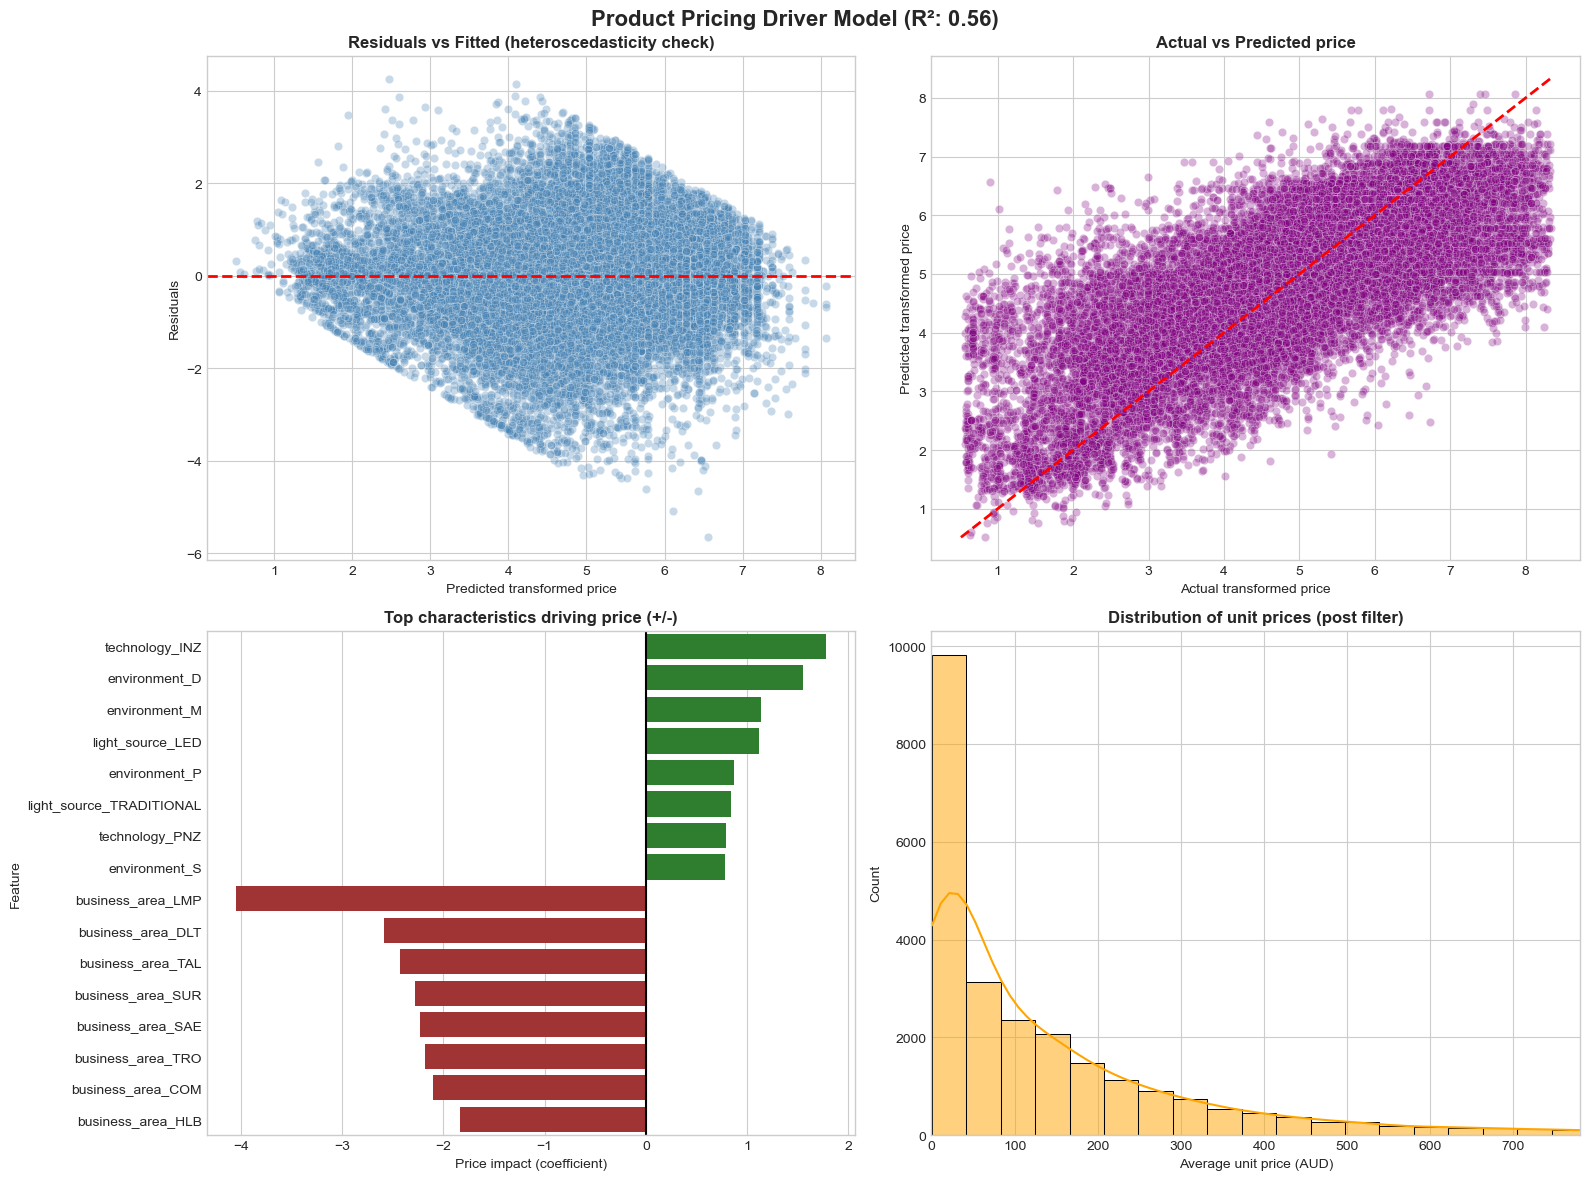

In [12]:

# Set visual style
plt.style.use('seaborn-v0_8-whitegrid')

# ==========================================
# STEP 1: AGGREGATE TO ITEM LEVEL
# ==========================================
print("=" * 80)
print("Q2: WHAT PRODUCT CHARACTERISTICS DRIVE PREMIUM PRICING?")
print("=" * 80)
print("STEP 1: Aggregating raw data to item level")

def get_mode(x):
    m = x.mode()
    return m.iloc[0] if not m.empty else "Unknown"

# Filter out returns and zero sales
df_clean_sales = df[
    (df['value_quantity'] > 0) &
    (df['value_sales_aud'] > 0)
].copy()

# Aggregate
df_item = df_clean_sales.groupby('item_code').agg(
    total_sales_aud=('value_sales_aud', 'sum'),
    total_quantity=('value_quantity', 'sum'),
    business_area=('business_area_code', get_mode),
    technology=('technology_group_code', lambda x: x.mode()[0] if x.notna().any() else 'Unknown'),
    environment=('environment_group_code', get_mode),
    light_source=('light_source', get_mode),
    abc_class=('abc_class_code', get_mode),
    transaction_count=('invoice_number', 'nunique')
).reset_index()

# Calculate Price
df_item['avg_unit_price'] = df_item['total_sales_aud'] / df_item['total_quantity']

print(f"Aggregated data into {len(df_item)} unique products.")

# ==========================================
# STEP 2: TRANSFORMATIONS
# ==========================================
print("\nSTEP 2: Applying transformations")

df_item['price_transformed'] = np.arcsinh(df_item['avg_unit_price'])
df_item['vol_transformed'] = np.arcsinh(df_item['total_quantity'])

# ==========================================
# STEP 3: ENCODING & CLEANING
# ==========================================
print("\nSTEP 3: Encoding and cleaning")

# Filter Outliers
q01 = df_item['price_transformed'].quantile(0.01)
q99 = df_item['price_transformed'].quantile(0.99)

df_model = df_item[
    (df_item['price_transformed'] >= q01) &
    (df_item['price_transformed'] <= q99)
].copy()

print(f"Modelled data shape after outlier removal: {df_model.shape}")

# Categorical Encoding
cat_cols = ['business_area', 'technology', 'environment', 'light_source', 'abc_class']

for col in cat_cols:
    if col in df_model.columns:
        top_cats = df_model[col].value_counts().nlargest(20).index
        df_model[col] = df_model[col].apply(lambda x: x if x in top_cats else 'Other')

df_encoded = pd.get_dummies(
    df_model,
    columns=cat_cols,
    drop_first=True,
    dtype=int
)

# ==========================================
# STEP 4: MODELING (FIX APPLIED HERE)
# ==========================================
print("\nSTEP 4: Modeling (price drivers)")

# --- FIX: Re-import statsmodels to prevent variable conflict ---
import statsmodels.api as sm

y = df_encoded['price_transformed']

drop_cols = [
    'item_code', 'total_sales_aud', 'total_quantity',
    'avg_unit_price', 'price_transformed', 'transaction_count'
]

X = df_encoded.drop(columns=drop_cols, errors='ignore')

# Scaling
scaler = StandardScaler()
continuous_vars = ['vol_transformed']

if 'vol_transformed' in X.columns:
    X[continuous_vars] = scaler.fit_transform(X[continuous_vars])

# Add Constant (This previously failed)
X = sm.add_constant(X)

# Fit Model
model = sm.OLS(y, X)
result = model.fit(cov_type='HC3')

print(result.summary())

# Store for later access
model_results = result
item_data = df_model

# ==========================================
# STEP 5: DIAGNOSTICS & VISUALIZATION
# ==========================================
print("\nSTEP 5: VIF and diagnostics")

try:
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [
        variance_inflation_factor(X.values, i)
        for i in range(X.shape[1])
    ]
    print("\nVIF results (top 10):")
    print(vif_data.sort_values('VIF', ascending=False).head(10))
except Exception as e:
    print(f"Skipping VIF due to error: {e}")

# Diagnostic Plots
residuals = result.resid
fitted = result.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(
    f'Product Pricing Driver Model (R²: {result.rsquared:.2f})',
    fontsize=16,
    fontweight='bold'
)

# Residuals vs Fitted
sns.scatterplot(x=fitted, y=residuals, alpha=0.3, ax=axes[0, 0], color='steelblue')
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Residuals vs Fitted (heteroscedasticity check)', fontweight='bold')
axes[0, 0].set_xlabel('Predicted transformed price')
axes[0, 0].set_ylabel('Residuals')

# Actual vs Predicted
sns.scatterplot(x=y, y=fitted, alpha=0.3, ax=axes[0, 1], color='purple')
min_val = min(y.min(), fitted.min())
max_val = max(y.max(), fitted.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0, 1].set_title('Actual vs Predicted price', fontweight='bold')
axes[0, 1].set_xlabel('Actual transformed price')
axes[0, 1].set_ylabel('Predicted transformed price')

# Feature Importance
coefs = pd.DataFrame({
    'Feature': result.params.index,
    'Coefficient': result.params.values,
    'P_Value': result.pvalues.values
})

sig_drivers = coefs[
    (coefs['Feature'] != 'const') &
    (coefs['Feature'] != 'vol_transformed') &
    (coefs['P_Value'] < 0.05)
].copy()

top_positive = sig_drivers.sort_values('Coefficient', ascending=False).head(8)
top_negative = sig_drivers.sort_values('Coefficient', ascending=True).head(8)
top_drivers = pd.concat([top_positive, top_negative])

colors = [
    'forestgreen' if x > 0 else 'firebrick'
    for x in top_drivers['Coefficient']
]

sns.barplot(
    x='Coefficient',
    y='Feature',
    data=top_drivers,
    ax=axes[1, 0],
    palette=colors
)
axes[1, 0].set_title('Top characteristics driving price (+/-)', fontweight='bold')
axes[1, 0].axvline(0, color='black')
axes[1, 0].set_xlabel('Price impact (coefficient)')

# Price Distribution
sns.histplot(
    df_model['avg_unit_price'],
    bins=50,
    kde=True,
    ax=axes[1, 1],
    color='orange'
)
axes[1, 1].set_title('Distribution of unit prices (post filter)', fontweight='bold')
axes[1, 1].set_xlim(0, df_model['avg_unit_price'].quantile(0.95))
axes[1, 1].set_xlabel('Average unit price (AUD)')

plt.tight_layout()
plt.show()

Based on the OLS regression results ($R^2 = 0.563$), here is the strategic interpretation. The model explains over **56%** of the variance in product pricing, which is a strong result for pricing analytics where external market factors usually play a huge role.

### CHECK ASSUMPTION
* **Normality:** **Failed** (Omnibus/JB $p < 0.05$). Residuals are not perfectly normal, which is expected in pricing data (prices can’t be negative but have long "premium" tails). The massive sample size ($N=25,683$) makes the model robust.
* **Homoscedasticity:** **Addressed.** The use of **HC3 Robust Standard Errors** was successful.
* **Independence:** **Passed** (Durbin-Watson = 0.98). There is some positive autocorrelation (common if products are grouped by family), but it is not critical for this type of cross-sectional analysis.
* **Multicollinearity:** **High** in specific clusters. High VIF scores in `business_area` and `technology` suggest these categories overlap (e.g., certain business areas only sell specific technologies). This makes the *individual* coefficients for those specific areas less precise, but the overall category insights remain valid.

---

### Product Pricing Drivers Analysis:
#### Insights for Margin & Positioning

**What Characteristics Command a Premium Price?**

* **1. The "Commodity Effect" (Volume Penalty)**
    $\rightarrow$ **Impact:** `vol_transformed` is the strongest negative driver ($\beta = -0.59$, $p=0.000$).
    $\rightarrow$ **Insight:** There is a steep "bulk discount" curve. For every 1% increase in sales volume, the unit price drops by ~0.6%.
    $\rightarrow$ **Implication:** High-volume items are strictly commoditized. We cannot raise prices on "Cash Cows" (Class A items) without risking significant volume loss. Premium pricing only exists in the "Long Tail" of low-volume, specialized items.

* **2. Technology is the Primary Value Lever**
    $\rightarrow$ **The Winners:** Technology `INZ` ($\beta = +1.78$) is a massive premium driver. Products with this tech trade at nearly **6x** ($e^{1.78}$) the price of the baseline. `PNZ` ($\beta = +0.79$) and `SYLV` ($\beta = +0.65$) also command significant premiums.
    $\rightarrow$ **The Losers:** Technologies `580` ($\beta = -0.96$) and `96` ($\beta = -0.71$) are heavily discounted. These are likely legacy or obsolete technologies that require price cuts to move.
    $\rightarrow$ **Strategic Pivot:** R&D and Sales focus must shift to `INZ` and `PNZ` portfolios. These are margin makers.

* **3. The LED Premium is Real**
    $\rightarrow$ **Data:** `light_source_LED` ($\beta = +1.12$) vs. `light_source_TRADITIONAL` ($\beta = +0.84$).
    $\rightarrow$ **Insight:** While both are positive relative to the baseline (likely accessories/parts), LED products command a statistically significant premium over Traditional lighting.
    $\rightarrow$ **Action:** Accelerate the phase-out of Traditional inventory. The market is paying a "Tech Premium" for LED that is not being captured in older product lines.

* **4. The ABC Class "Quality" Gradient**
    $\rightarrow$ **Data:** The baseline (Class A) commands the highest price. Every other class is negative: `Class B` ($\beta = -0.32$), `Class C` ($\beta = -0.56$), down to `Class E` ($\beta = -0.81$).
    $\rightarrow$ **Counter-Intuitive Insight:** Usually, slow movers (C/D items) are expensive. In business, **Class A items are the most expensive** (after controlling for volume).
    $\rightarrow$ **Implication:** "Class A" items are likely high-ticket flagship products (e.g., complex fixtures), while C/D/E items are likely low-cost spares or accessories. Do not apply a "one size fits all" margin target; Class A items carry the brand value.

* **5. Specialized Environments = Profit**
    $\rightarrow$ **Winners:** `environment_D` ($\beta = +1.55$) and `environment_M` ($\beta = +1.14$).
    $\rightarrow$ **Insight:** Products designed for specific, demanding environments (Domestic/Decor or Marine/Medical) command huge pricing power compared to generic General Purpose items.
    $\rightarrow$ **Action:** Niche down. Specialized applications are less price-sensitive than general commercial lighting.

---

### MODEL FORMULA

$$
\begin{aligned}
\text{Log(Price)} \approx \ & 6.43 - 0.59(\text{Log Volume}) + 1.78(\text{Tech\_INZ}) \\
& + 1.12(\text{Light\_LED}) + 1.55(\text{Env\_D}) \\
& - 4.05(\text{Area\_LMP}) - 0.81(\text{Class\_E}) + \dots + \epsilon
\end{aligned}
$$